## Theories of Expectation Formation

- The code is organized in following ways

  1. Each pair of a theory of expectation formation (re, se, ni, de, deni etc) and an assumed process of inflation process (ar1 or sv)  are encapsulated in a specific python class.
    - the class initializes corresponding parameters of the inflation process and expectation formation 
    - and embodies a specific function that generates all the simulated moments of both inflation and expectations 
    
  2. A generally written objective function that computes the distances in moments as a function of parameters specific to the chosen model, moments, and the data. 
  3.  The general function is to be used to compute the specific objective function that takes parameter as the only input for the minimizer to work
  4.  Then a general function that does an optimization algorithm takes the specific objective function and estimates the parameters

In [1]:
import numpy as np
from scipy.optimize import minimize
from numba import njit, float64, int64
from numba.experimental import jitclass
import matplotlib.pyplot as plt

## Model 

In [2]:
## auxiliary functions 
@njit
def hstepvar(h,
             ρ,
             σ):
    '''
    inputs
    ------
    h: forecast horizon
    ρ: ar(1) persistence
    σ: ar(1) volatility (standard deviation)
    
    outputs
    -------
    scalar: h-step-forward variance 
    '''
    ## h-step ahead variance for an ar(1)
    var = 0
    for i in range(h):
        var += ρ**(2*i)*σ**2 
    return var 

@njit
def hstepvarSV(h,
               σs_now,
               γ):
    '''
    inputs
    ------
    h: forecast horizon
    σs_now, 2 x 1 vector [sigma_eta, sigma_eps]
    γ, volatility, scalar. 
    
    outputs
    -------
    scalar: h-step-forward variance 
    '''
    ratio = 0
    for k in range(h):
        ratio += np.exp(-0.5*(k+1)*γ)
    var_eta = σs_now[0]**2*ratio
    var_eps = σs_now[1]**2*np.exp(-0.5*h*γ)
    var = var_eta + var_eps
    return var

### AR1 simulator 
@njit
def SimAR1(ρ,
           σ,
           T):
    '''
    inputs
    ------
    T: nb of periods for the simulated history 
    ρ: ar(1) persistence
    σ: ar(1) volatility (standard deviation)
    
    outputs
    -------
    xxx: T periods of history of AR(1) with the first 20 periods burned 
    '''
        
    t_burn = 20
    xxx = np.zeros(T+1+t_burn)
    shocks = np.random.randn(T+1+t_burn)*σ
    xxx[0] = 0 
    for i in range(T+t_burn):
        xxx[i+1] = ρ*xxx[i] + shocks[i+1]
    return xxx[1+t_burn:]

### UC-SV simulator 
@njit
def SimUCSV(γ,
            nobs,
            p0 = 0,
            seed = False):
    """
    input
    ======
    p: permanent 
    t: transitory 
    
    output
    ======
    y: the draw of series
    p: the permanent component
    svols_p: permanent volatility 
    svols_t: transitory volatility 
    """
    if seed:
        np.random.seed(12344)
    else:
        pass
    svols_p_shock = np.random.randn(nobs+1)*γ
    svols_t_shock = np.random.randn(nobs+1)*γ
    
    svols_p = np.zeros(nobs+1)
    svols_p[0] = 0.001
    svols_t = np.zeros(nobs+1)
    svols_t[0] = 0.001
    for i in range(nobs):
        svols_p[i+1] = np.sqrt( np.exp(np.log(svols_p[i]**2) + svols_p_shock[i+1]) ) 
        svols_t[i+1] = np.sqrt( np.exp(np.log(svols_t[i]**2) + svols_t_shock[i+1]) ) 
    shocks_p = np.multiply(np.random.randn(nobs+1),svols_p)  
    shocks_t = np.multiply(np.random.randn(nobs+1),svols_t)
    
    p = np.zeros(nobs+1)
    t = np.zeros(nobs+1)
    
    ## initial level of eta, 0 by default
    p[0] = p0
    
    for i in range(nobs):
        p[i+1] = p[i] + shocks_p[i+1]
        t[i+1] = shocks_t[i+1]
        
    y = p + t
    return y, p, svols_p, svols_t

@njit
def d1tod2(x):
    '''
    inputs
    ------
    x: 1-dimension array 
    
    outputs
    -------
    2-dimension array 
    '''
    return x.reshape(1,-1)

In [3]:
## Objective functions for SMM
@njit
def ObjGen(model,
           paras,
           data_mom_dict,
           moment_choice,
           how = 'expectation',
           n_exp_paras = 0):
    '''
    inputs
    ------
    model: a model class, i.e, sear representing sticky expectation and ar(1) 
    paras: an array vector of the parameters, which potentially includes both inflation process and expectation 
    data_mom_dic: a dictionary storing all data moments
    moment_choice: a list of moments, i.e. ['FE','FEATV','Var']
    how: string taking values of 'expectation','process','joint'
    n_exp_paras: nb of parameters for expectation model 
    
    outputs
    -------
    distance: the scalar of the moment distances to be minimized
    '''
    if how =='expectation':
        model.exp_para = paras
    elif how=='process':
        model.process_para = paras
    elif how=='joint':
        model.exp_para = paras[0:n_exp_paras]
        model.process_para = paras[n_exp_paras:]
        
    # simulated moments 
    model_mom_dict = model.SMM()
    diff = np.array([model_mom_dict[mom] - data_mom_dict[mom] for mom in moment_choice]) 
    distance = np.linalg.norm(diff)
    
    return distance

@njit
def ObjWeight(model,
           paras,
           data_mom_dict,
           moment_choice,
           weight,
           how = 'expectation',
           n_exp_paras = 0):
    '''
    - same as above ObjGen, except for with one additional argument weight for weighted distance 
    '''
    
    if how =='expectation':
        model.exp_para = paras
    elif how=='process':
        model.process_para = paras
    elif how=='joint':
        model.exp_para = paras[0:n_exp_paras]
        model.process_para = paras[n_exp_paras:]
        
    # simulated moments 
    model_mom_dict = model.SMM()
    diff = np.array([model_mom_dict[mom] - data_mom_dict[mom] for mom in moment_choice])
    distance = np.dot(np.dot(diff,weight),diff.T)  ## need to make sure it is right. 
    return distance

In [4]:
## parameter estimation non-jitted because jit does not support scipy.optimize
def ParaEst(ObjSpec,
            para_guess,
            method = 'Nelder-Mead',
            bounds = None,
            options = {'disp': True,
                      'maxiter': 1500}):
    """
    an estimating function that minimizes OjbSpec function that gives parameter estimates
    """
    results = minimize(ObjSpec,
                         x0 = para_guess,
                         method = method,
                         bounds = bounds,
                         options = options)
    if results['success']==True:
        parameter = results['x']
    else:
        #parameter = np.array([])
        parameter = np.nan
    return parameter 

In [72]:
### Some jitted functions that are needed (https://github.com/numba/numba/issues/1269)

@njit
def np_apply_along_axis(func1d, axis, arr):
    assert arr.ndim == 2
    assert axis in [0, 1]
    if axis == 0:
        result = np.empty(arr.shape[1])
        for i in range(len(result)):
            result[i] = func1d(arr[:, i])
    else:
        result = np.empty(arr.shape[0])
        for i in range(len(result)):
            result[i] = func1d(arr[i, :])
    return result

@njit
def np_mean(array, axis):
    return np_apply_along_axis(np.mean, axis, array)

@njit
def np_std(array, axis):
    return np_apply_along_axis(np.std, axis, array)

@njit
def np_var(array, axis):
    return np_apply_along_axis(np.var, axis, array)

@njit
def np_max(array, axis):
    return np_apply_along_axis(np.max, axis, array)


@njit
def np_min(array, axis):
    return np_apply_along_axis(np.min, axis, array)

### Rational Expectation (RE) + AR1

In [73]:
model_data = [
    ('exp_para', float64[:]),             # parameters for expectation formation, empty for re
    ('process_para', float64[:]),         # parameters for inflation process, 2 entries for AR1 
    ('horizon', int64),                   # forecast horizons 
    ('real_time',float64[:]),             # real time data on inflation 
    ('history',float64[:]),               # a longer history of inflation 
    ('realized',float64[:])               # realized inflation 
]

In [74]:
@jitclass(model_data)
class RationalExpectationAR:
    def __init__(self,
                 exp_para,
                 process_para,
                 real_time,
                 history,
                 horizon = 1):
        self.exp_para = exp_para
        self.process_para = process_para
        if process_para[0] >1:
            print("Warning:persistent parameter cannot be more than 1")
            self.process_para[0] = 1.0
        self.horizon = horizon
        self.real_time = real_time
        self.history = history

    def GetRealization(self,
                       realized_series):
        self.realized = realized_series
        
    def SimForecasts(self):
        ## parameters
        n = len(self.real_time)
        ρ,σ = self.process_para
        horizon = self.horizon

        ## information set 
        real_time = self.real_time
        
        ## forecast moments 
        Disg = np.zeros(n)
        nowcast = real_time
        forecast = ρ**horizon*nowcast
        Var = hstepvar(horizon,ρ,σ)* np.ones(n)
        FE = forecast - self.realized           ## forecast errors depend on realized shocks
        FEATV = np.zeros(n)
        forecast_moments = {"Forecast":forecast,
                            "FE":FE,
                            "Disg":Disg,
                            "Var":Var}
        return forecast_moments
    
    def SMM(self):
        
        ρ,σ = self.process_para
        horizon = self.horizon
        #################################
        # inflation moments 
        #################################

        InfAV  = 0.0
        if ρ <1.0:
            InfVar = σ**2/(1-ρ**2)
        else:
            Infvar = np.inf
        InfATV = ρ**horizon*InfVar
        
        #################################
        # expectation moments 
        #################################
        ## simulate forecasts
        
        moms_sim = self.SimForecasts()
        
        Forecasts_sim = moms_sim['Forecast']
        FEs_sim = moms_sim['FE']
        Disgs_sim = moms_sim['Disg']
        Vars_sim = moms_sim['Var']
        
        ## SMM moments   
        Forecast_sim = np.mean(Forecasts_sim)
        FE_sim = np.mean(FEs_sim)
        FEVar_sim = np.var(FEs_sim)
        FEATV_sim = np.cov(np.stack( (FEs_sim[horizon:],FEs_sim[:-horizon]),axis = 0 ))[0,1]
        Disg_sim = np.mean(Disgs_sim)
        DisgVar_sim = np.var(Disgs_sim)
        DisgATV_sim = np.cov(np.stack( (Disgs_sim[horizon:],Disgs_sim[:-horizon]),axis = 0))[0,1]
        
        Var_sim = np.mean(Vars_sim)
        VarVar_sim = np.var(Vars_sim)
        VarATV_sim = np.cov(np.stack( (Vars_sim[horizon:],Vars_sim[:-horizon]),axis = 0))[0,1]
    
        SMMMoments = {"InfAV":InfAV,
                      "InfVar":InfVar,
                      "InfATV":InfATV,
                      "Forecasts":Forecast_sim,
                      "FE":FE_sim,
                      "FEVar":FEVar_sim,
                      "FEATV":FEATV_sim,
                      "Disg":Disg_sim,
                      "DisgVar":DisgVar_sim,
                      "DisgATV":DisgATV_sim,
                      "Var":Var_sim,
                      'VarVar':VarVar_sim,
                      'VarATV':VarATV_sim}
        return SMMMoments
    
    def GMM(self):
        ρ,σ = self.process_para
        horizon = self.horizon
        
        GMMMoments = {"InfAV":0.0,
                      "InfVar":σ**2/(1-ρ**2),
                      "InfATV":ρ*σ**2/(1-ρ**2),
                      "Forecasts":0.0,
                      "FE":0.0,
                      "FEVar":sum([ρ**(2*k)*σ**2 for k in range(horizon)]),
                      "FEATV":0.0,
                      "Disg":0.0,
                      "DisgVar":0.0,
                      "DisgATV":0.0,
                      "Var":sum([ρ**k*σ**2 for k in range(horizon)]),
                      'VarVar':0.0,
                      'VarATV':0.0}
        
        return GMMMoments

### Some simulated data 

- Creating some simulated inflation data following AR1 and UCSV process separately 

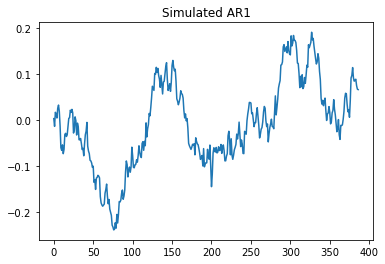

In [75]:
if __name__ == "__main__":
       
    T_sim = 400
    ## first, simulate some AR1 inflation with known parameters 
    ρ0,σ0 = 0.98,0.02
    history0 = SimAR1(ρ0,
                      σ0,
                      T_sim)
    real_time0 = history0[11:-2] 
    realized0 = history0[12:-1]
    
    ## plot
    plt.plot(realized0)
    plt.title('Simulated AR1')

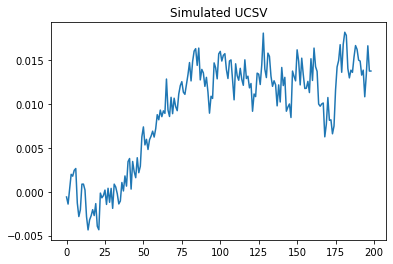

In [76]:
if __name__ == "__main__":
    ### create a RESV instance 

    p0_fake = 0
    γ_fake = 0.1
    σs_now_fake = [0.2,0.3]

    ucsv_fake = SimUCSV(γ_fake,
                        nobs = 200,
                        p0 = p0_fake,
                        ) 

    xx_real_time,xx_p_real_time,vol_p_real_time,vol_t_real_time = ucsv_fake  

    xx_realized = xx_real_time[1:-1]

    xx_real_time = np.array([xx_real_time,
                            xx_p_real_time,
                            vol_p_real_time,
                            vol_t_real_time]
                          )[:,0:-2]
    
     ## plot
    plt.plot(xx_realized)
    plt.title('Simulated UCSV')

#### Estimation the parameters of the inflation process jointly using both inflation and rational expectation forecasts

- For instance, the example below shows that how auto-covariance (ATV) of inflation, the rational forecast error, and forecast uncertainty together identify the rho and sigma of inflation correctly. 


In [77]:
if __name__ == "__main__":


    ## initialize an re instance 
    rear0 = RationalExpectationAR(exp_para = np.array([]),
                                  process_para = np.array([ρ0,σ0]),
                                  real_time = real_time0,
                                  history = history0,
                                  horizon = 1)
    
    rear0.GetRealization(realized0) 

    ## fake data moments dictionary 
    
    data_mom_dict_re = rear0.SMM()
        
    ## specific objective function for estimation 
    
    moments1 = ['FE', ## 
                'Var'] ## helps identify sigma

    ## specific objective function 
    def Objrear(paras):
        scalor = ObjGen(rear0,
                        paras = paras,
                        data_mom_dict = data_mom_dict_re,
                        moment_choice = moments1,
                        how = 'joint')
        return scalor
    
    ## invoke estimation
    est = ParaEst(Objrear,
            para_guess = (0.7,0.2))
    
    print('True parameters: ',str(np.array([ρ0,σ0])))
    print('Estimates: ',str(est))

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'moment_choice' of function 'ObjGen'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_82986/2685684584.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 70
True parameters:  [0.98 0.02]
Estimates:  [0.9800334  0.02000177]


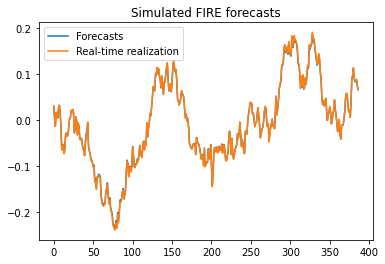

In [78]:
if __name__ == "__main__":
    ## plot for validation 
    simulated_re  = rear0.SimForecasts()
    plt.title("Simulated FIRE forecasts")
    plt.plot(simulated_re['Forecast'],label='Forecasts')
    plt.plot(rear0.real_time,label='Real-time realization')
    plt.legend(loc=0)

In [79]:
if __name__ == "__main__":

    ## check if simulated moments and computed moments match 
    data_mom_dict_re_computed = rear0.GMM()
    
    print("Simulated moments:",data_mom_dict_re)
    print('\n')
    print("Computed moments:",data_mom_dict_re_computed)

Simulated moments: {InfAV: 0.0, InfVar: 0.010101010101010081, InfATV: 0.00989898989898988, Forecasts: -0.009379887812296941, FE: 9.948159332922794e-05, FEVar: 0.0003560554002232809, FEATV: 5.839763932716877e-06, Disg: 0.0, DisgVar: 0.0, DisgATV: 0.0, Var: 0.00040000000000000083, VarVar: 6.612155723375367e-37, VarATV: 6.629330153825693e-37}


Computed moments: {InfAV: 0.0, InfVar: 0.010119522190683176, InfATV: 0.009917469720210317, Forecasts: 0.0, FE: 0.0, FEVar: 0.0004000706397153937, FEATV: 0.0, Disg: 0.0, DisgVar: 0.0, DisgATV: 0.0, Var: 0.0004000706397153937, VarVar: 0.0, VarATV: 0.0}


### Rational Expectation (RE) + SV

In [80]:
model_sv_data = [
    ('exp_para', float64[:]),             # parameters for expectation formation, empty for re
    ('process_para', float64[:]),         # parameters for inflation process, 2 entries for AR1 
    ('horizon', int64),                   # forecast horizons 
    ('real_time',float64[:,:]),           # real time data on inflation
    ('history',float64[:,:]),             # a longer history of inflation 
    ('realized',float64[:])               # realized inflation 
]

In [81]:
@jitclass(model_sv_data)
class RationalExpectationSV:
    def __init__(self,
                 exp_para,
                 process_para,
                 real_time,
                 history,
                 horizon = 1):
        self.exp_para = exp_para
        self.process_para = process_para
        self.horizon = horizon
        self.real_time = real_time
        self.history = history

    def GetRealization(self,
                       realized_series):
        self.realized = realized_series
        
    def SimForecasts(self):
        ## parameters
        n = len(self.real_time[0,:]) ## real_time has multiple rows 
        γ = self.process_para
            
        ## inputs
        real_time = self.real_time
        horizon = self.horizon
        
        ## forecast moments 
        ## now the information set needs to contain different components separately.
        ## therefore, real_time fed in the begining is a tuple, not just current eta, but also current sigmas. 
        
        infoset = real_time 
        y_real_time = infoset[0,:]  ## permanent component 
        nowcast = infoset[1,:]  ## permanent component 
        forecast = nowcast      ## rational forecase is just the current permanent component
        σs_now = infoset[2:3,:]  ## volatility now for each component
        
        Var = np.zeros(n)
        for i in range(n):
            Var[i] = hstepvarSV(horizon,
                                σs_now = σs_now[:,i],
                                γ = γ[0]) ## γ[0] instead of γ is important make sure the input is a float
        FE = forecast - self.realized ## forecast errors depend on realized shocks 
        Disg = np.zeros(n)
        
        forecast_moments = {"Forecast":forecast,
                            "FE":FE,
                            "Disg":Disg,
                            "Var":Var}
        return forecast_moments
        
    def SMM(self):
        
        γ = self.process_para
        horizon = self.horizon
        
        #################################
        # inflation moments 
        #################################

        InfAV  = 0.0
        InfVar = np.nan
        InfATV = np.nan
        
        #################################
        # expectation moments 
        #################################
        ## simulate forecasts
        moms_sim = self.SimForecasts()
        
        Forecasts_sim = moms_sim['Forecast']
        FEs_sim = moms_sim['FE']
        Disgs_sim = moms_sim['Disg']
        Vars_sim = moms_sim['Var']
        
        ## SMM moments  
        Forecast_sim = np.mean(Forecasts_sim)
        FE_sim = np.mean(FEs_sim)
        FEVar_sim = np.var(FEs_sim)
        FEATV_sim = np.cov(np.stack( (FEs_sim[horizon:],FEs_sim[:-horizon]),axis = 0 ))[0,1]
        Disg_sim = np.mean(Disgs_sim)
        DisgVar_sim = np.var(Disgs_sim)
        DisgATV_sim = np.cov(np.stack( (Disgs_sim[horizon:],Disgs_sim[:-horizon]),axis = 0))[0,1]
        
        Var_sim = np.mean(Vars_sim)
        VarVar_sim = np.var(Vars_sim)
        VarATV_sim = np.cov(np.stack( (Vars_sim[horizon:],Vars_sim[:-horizon]),axis = 0))[0,1]
    
        SMMMoments = {"InfAV":InfAV,
                      "InfVar":InfVar,
                      "InfATV":InfATV,
                      "Forecast":Forecast_sim,
                      "FE":FE_sim,
                      "FEVar":FEVar_sim,
                      "FEATV":FEATV_sim,
                      "Disg":Disg_sim,
                      "DisgVar":DisgVar_sim,
                      "DisgATV":DisgATV_sim,
                      "Var":Var_sim,
                      'VarVar':VarVar_sim,
                      'VarATV':VarATV_sim}
        return SMMMoments
    
    def GMM(self):
        print('not implemented yet!')
        return None

In [82]:
if __name__ == "__main__":
    ### create a RESV instance 
    resv = RationalExpectationSV(exp_para = np.array([]),
                                 process_para = np.array([0.1]),
                                 real_time = xx_real_time,
                                 history = xx_real_time) ## history does not matter here for RE 

    ## get the realization 
    resv.GetRealization(xx_realized)

### Sticky Expectation (SE) + AR1

In [83]:
@jitclass(model_data)
class StickyExpectationAR:
    def __init__(self,
                 exp_para,
                 process_para,
                 real_time,
                 history,
                 horizon = 1):
        self.exp_para = exp_para
        self.process_para = process_para
        if process_para[0] >1:
            print("Warning:persistent parameter cannot be more than 1")
            self.process_para[0] = 1.0
        self.horizon = horizon
        self.real_time = real_time
        self.history = history

    def GetRealization(self,
                       realized_series):
        self.realized = realized_series
        
    def SimForecasts(self,
                     n_sim = 500):        
        ## parameters and inputs 
        real_time = self.real_time
        history  = self.history
        
        n = len(real_time)
        ρ,σ = self.process_para
        lbd = self.exp_para
        horizon = self.horizon
        
        n_history = len(history) # of course equal to len(history)
        n_burn = len(history) - n
        
        ## simulation
        np.random.seed(12345)
        update_or_not_val = np.random.uniform(0,
                                              1,
                                              size = (n_sim,n_history))
        update_or_not_bool = update_or_not_val>=1-lbd
        update_or_not = update_or_not_bool.astype(np.int64)
        most_recent_when = np.empty((n_sim,n_history),dtype = np.int64)
        nowcasts_to_burn = np.empty((n_sim,n_history),dtype = np.float64)
        Vars_to_burn = np.empty((n_sim,n_history),dtype = np.float64)
        
        # look back for the most recent last update for each point of time  
        for i in range(n_sim):
            for j in range(n_history):
                most_recent = j 
                for x in range(j):
                    if update_or_not[i,j-x]==1 and most_recent<=x:
                        most_recent = most_recent
                    elif update_or_not[i,j-x]==1 and most_recent>x:
                        most_recent = x
                most_recent_when[i,j] = most_recent
                nowcasts_to_burn[i,j] = history[j - most_recent_when[i,j]]*ρ**most_recent_when[i,j]
                Vars_to_burn[i,j]= hstepvar((most_recent_when[i,j]+horizon),
                                            ρ,
                                            σ)
        
        ## burn initial forecasts since history is too short 
        nowcasts = nowcasts_to_burn[:,n_burn:] 
        forecasts = ρ**horizon*nowcasts
        Vars = Vars_to_burn[:,n_burn:]
        FEs = forecasts - self.realized
        
        ## compute population moments
        forecasts_mean = np_mean(forecasts,axis = 0)
        forecasts_var = np_var(forecasts,axis = 0)
        FEs_mean = forecasts_mean - self.realized
            
        Vars_mean = np_mean(Vars,axis = 0) ## need to change 
        
        forecasts_vcv = np.cov(forecasts.T)
        forecasts_atv = np.array([forecasts_vcv[i+1,i] for i in range(n-1)])
        FEs_vcv = np.cov(FEs.T)
        FEs_atv = np.array([FEs_vcv[i+1,i] for i in range(n-1)]) ## this is no longer needed
        
        forecast_moments_sim = {"Forecast":forecasts_mean,
                                "FE":FEs_mean,
                                "Disg":forecasts_var,
                                "Var":Vars_mean}
        return forecast_moments_sim
            
    def SMM(self):
        
        ρ,σ = self.process_para
        horizon = self.horizon
        
        #################################
        # inflation moments 
        #################################

        InfAV  = 0.0
        if ρ <1.0:
            InfVar = σ**2/(1-ρ**2)
        else:
            Infvar = np.inf
        InfATV = ρ**horizon*InfVar
        
        #################################
        # expectation moments 
        #################################
        ## simulate forecasts
        moms_sim = self.SimForecasts()
        
        Forecasts_sim = moms_sim['Forecast']
        FEs_sim = moms_sim['FE']
        Disgs_sim = moms_sim['Disg']
        Vars_sim = moms_sim['Var']
        
        ## SMM moments     
        Forecast_sim = np.mean(Forecasts_sim)
        FE_sim = np.mean(FEs_sim)
        FEVar_sim = np.var(FEs_sim)
        FEATV_sim = np.cov(np.stack( (FEs_sim[horizon:],FEs_sim[:-horizon]),axis = 0 ))[0,1]
        Disg_sim = np.mean(Disgs_sim)
        DisgVar_sim = np.var(Disgs_sim)
        DisgATV_sim = np.cov(np.stack( (Disgs_sim[horizon:],Disgs_sim[:-horizon]),axis = 0))[0,1]
        
        Var_sim = np.mean(Vars_sim)
        VarVar_sim = np.var(Vars_sim)
        VarATV_sim = np.cov(np.stack( (Vars_sim[horizon:],Vars_sim[:-horizon]),axis = 0))[0,1]
    
        SMMMoments = {"InfAV":InfAV,
                      "InfVar":InfVar,
                      "InfATV":InfATV,
                      "Forecast":Forecast_sim,
                      "FE":FE_sim,
                      "FEVar":FEVar_sim,
                      "FEATV":FEATV_sim,
                      "Disg":Disg_sim,
                      "DisgVar":DisgVar_sim,
                      "DisgATV":DisgATV_sim,
                      "Var":Var_sim,
                      'VarVar':VarVar_sim,
                      'VarATV':VarATV_sim}
        return SMMMoments
    
    def GMM(self):
        ρ,σ = self.process_para
        horizon = self.horizon
        lbd = self.exp_para[0]
        
        ## some middle steps for moments below 
        cum_fe2_sum = np.sum(np.array([ρ**(2*k)*σ**2 for k in range(horizon)]))
        fe_var_ratio = lbd**2/(1-(1-lbd)**2*ρ**2)
        fevar = fe_var_ratio*cum_fe2_sum
        featv = (1-lbd)*ρ*fevar
        var_ratio = (lbd*ρ**(2*horizon)/(1-ρ**2+lbd*ρ**2)-1)/(ρ**2-1)
        var = var_ratio*σ**2
        
        disg_first_part = 1/(1-(1-lbd)**2*ρ**2)
        disg_second_part = 1/(1-(1-lbd)**6*ρ**4)
        disg = (disg_first_part-disg_second_part)*lbd*(1-lbd)*ρ**(2*horizon)**σ**2
        
        ##
        GMMMoments = {"InfAV":0.0,
                     "InfVar":σ**2/(1-ρ**2),
                      "InfATV":ρ*σ**2/(1-ρ**2),
                     "Forecasts":0.0,
                      "FE":0.0,
                      "FEVar":fevar,  
                      "FEATV":featv,
                      "Disg":disg,
                      "DisgVar":0.0,
                      "DisgATV":0.0,
                      "Var":var,
                      'VarVar':0.0,
                      'VarATV':0.0
                     }
        
        return GMMMoments

In [84]:
if __name__ == "__main__":


    ## initialize the ar instance 
    sear0 = StickyExpectationAR(exp_para = np.array([0.2]),
                                process_para = np.array([ρ0,σ0]),
                                real_time = real_time0,
                                history = history0,
                                horizon = 1)

    sear0.GetRealization(realized0)

#### Estimating SE with RE 

- The example below shows that a SEAR class correctly identifies the update rate lambda to be 1 if expectation moments from rational expectation are used.

In [85]:
if __name__ == "__main__":

    ## only expectation estimation 

    moments0 = [#'FE',
               #'FEATV',
                'FEVar',
               'Disg',
                'Var'
               ] ## or FE+Var, or FE + Disg

    def Objsear_re(paras):
        scalar = ObjGen(sear0,
                        paras = paras,
                        data_mom_dict = data_mom_dict_re,
                        moment_choice = moments0,
                        how = 'expectation')
        return scalar


    ## invoke estimation 
    Est = ParaEst(Objsear_re,
            para_guess = (0.0),
            method='Nelder-Mead',
            bounds = ((0,1.0),)
           )

    
    print('True parameters: ',str(np.array(1.0))) ## rational expectations 
    print('Estimates: ',str(Est))

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'moment_choice' of function 'ObjGen'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_82986/2685684584.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 26
True parameters:  1.0
Estimates:  [1.]


#### Estimating SE with SE 

- SEAR SMM correctly identifies rigidity parameter in SE 

In [86]:
if __name__ == "__main__":
    ## get a fake data moment dictionary under a different parameter 
    
    se_exp_para_fake = np.array([0.4])
    sear1 = StickyExpectationAR(exp_para = se_exp_para_fake,
                                process_para = np.array([ρ0,σ0]),
                                real_time = real_time0,
                                history = history0,
                                horizon = 1)
    sear1.GetRealization(realized0)
    data_mom_dict_se = sear1.SMM()

    moments0 = [#'FE',
                'FEATV', ## autocovariance of FE is critical to identify lambda in SE
                'FEVar',
                'Disg',   ## or Disg alone is also enough 
                #'Var'
               ]
    def Objsear_se(paras):
        scalar = ObjGen(sear0,
                        paras = paras,
                        data_mom_dict = data_mom_dict_se,
                        moment_choice = moments0,
                        how = 'expectation')
        return scalar


    ## invoke estimation 
    Est = ParaEst(Objsear_se,
           para_guess = (0.1),
            method='Nelder-Mead',
            bounds = ((0,1),))
    print('True parameter',str(se_exp_para_fake))  
    print('Estimates: ',str(Est))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 34
True parameter [0.4]
Estimates:  [0.4]


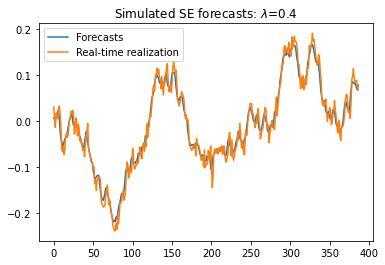

In [87]:
if __name__ == "__main__":
    ## plot for validation 
    simulated_sear  = sear1.SimForecasts()
    plt.title(r"Simulated SE forecasts: $\lambda$={}".format(sear1.exp_para[0]))
    plt.plot(simulated_sear['Forecast'],
             label='Forecasts')
    plt.plot(sear1.real_time,
             label='Real-time realization')
    plt.legend(loc=0)

#### Joint Estimation 

- The joint estimation below illustrates the mutual-dependence between the stickiness parameter and AR1 coefficients.

In [88]:
if __name__ == "__main__":

    ## for joint estimation 

    moments1 = ['InfAV',
                'InfVar',
                'InfATV',
                #'FE',
                'FEVar',
                'FEATV',
                'Disg',
               'Var'
               ]

    def Objsear_joint(paras):
        scalar = ObjGen(sear0,
                        paras = paras,
                        data_mom_dict = data_mom_dict_se,
                        moment_choice = moments1,
                        how ='joint',
                        n_exp_paras = 1)
        return scalar

    ## invoke estimation 
    Est = ParaEst(Objsear_joint,
            para_guess = np.array([0.1,0.95,0.05]),
            method='Nelder-Mead'
           )
    print('True process parameters: ',str(np.array([ρ0,σ0])))
    print('Estimates: ',str(Est[1:]))
    print('True expectation parameter',str(se_exp_para_fake))  
    print('Estimates: ',str(Est[0]))

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'moment_choice' of function 'ObjGen'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_82986/2685684584.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 225
         Function evaluations: 394
True process parameters:  [0.98 0.02]
Estimates:  [0.97999763 0.02000114]
True expectation parameter [0.4]
Estimates:  0.4000678589431834


In [89]:
if __name__ == "__main__":

    ## check if simulated moments and computed moments match 
    data_mom_dict_se_computed = sear1.GMM()
    
    print("Simulated moments:",data_mom_dict_se)
    print('\n')
    print("Computed moments:",data_mom_dict_se_computed)

Simulated moments: {InfAV: 0.0, InfVar: 0.010101010101010081, InfATV: 0.00989898989898988, Forecast: -0.00896621279561357, FE: 0.0005131566100125893, FEVar: 0.00015565863605859282, FEATV: 1.7012708260210692e-05, Disg: 0.0002912580568900049, DisgVar: 4.802571774729296e-08, DisgATV: 3.349618942567044e-08, Var: 0.0009427988426018467, VarVar: 8.733525705146921e-10, VarATV: 4.908538174623236e-10}


Computed moments: {InfAV: 0.0, InfVar: 0.010101010101010081, InfATV: 0.00989898989898988, Forecasts: 0.0, FE: 0.0, FEVar: 9.782103641388082e-05, FEATV: 5.751876941136192e-05, Disg: 0.11371491253269139, DisgVar: 0.0, DisgATV: 0.0, Var: 0.0009439305267132337, VarVar: 0.0, VarATV: 0.0}


### Sticky Expectation (SE) + SV

In [70]:
@jitclass(model_sv_data)
class StickyExpectationSV:
    def __init__(self,
                 exp_para,
                 process_para,
                 real_time,
                 history,
                 horizon = 1):
        self.exp_para = exp_para
        self.process_para = process_para
        self.horizon = horizon
        self.real_time = real_time
        self.history = history

    def GetRealization(self,
                       realized_series):
        self.realized = realized_series
        
    def SimForecasts(self,
                     n_sim = 502):        
        ## inputs 
        real_time = self.real_time
        history  = self.history
        n = len(real_time[0,:])
        horizon = self.horizon
        n_history = len(history[0,:]) # of course equal to len(history)
        n_burn = n_history - n
        
        ## get the information set 
        infoset = history 
        y_now,p_now, sigmas_p_now, sigmas_t_now= infoset[0,:],infoset[1,:],infoset[2,:],infoset[3,:]
        sigmas_now = np.concatenate((sigmas_p_now,sigmas_t_now),axis=0).reshape((2,-1))
        
        ## parameters 
        γ = self.process_para
        lbd = self.exp_para
       
        ## simulation
        np.random.seed(12345)
        update_or_not_val = np.random.uniform(0,
                                              1,
                                              size = (n_sim,n_history))
        update_or_not_bool = update_or_not_val>=1-lbd
        update_or_not = update_or_not_bool.astype(np.int64)
        most_recent_when = np.empty((n_sim,n_history),dtype = np.int64)
        nowcasts_to_burn = np.empty((n_sim,n_history),dtype = np.float64)
        Vars_to_burn = np.empty((n_sim,n_history),dtype = np.float64)
        
        # look back for the most recent last update for each point of time  
        for i in range(n_sim):
            for j in range(n_history):
                most_recent = j 
                for x in range(j):
                    if update_or_not[i,j-x]==1 and most_recent<=x:
                        most_recent = most_recent
                    elif update_or_not[i,j-x]==1 and most_recent>x:
                        most_recent = x
                most_recent_when[i,j] = most_recent
                ###########################################################################
                nowcasts_to_burn[i,j] = p_now[j - most_recent_when[i,j]]
                Vars_to_burn[i,j]= hstepvarSV((most_recent_when[i,j]+horizon),
                                              sigmas_now[:,j-most_recent_when[i,j]],
                                              γ[0])
                ###############################################################
        
        ## burn initial forecasts since history is too short 
        nowcasts = nowcasts_to_burn[:,n_burn:] 
        forecasts = nowcasts
        Vars = Vars_to_burn[:,n_burn:]
        FEs = forecasts - self.realized
        
        ## compuate population moments
        forecasts_mean = np_mean(forecasts,axis = 0)
        forecasts_var = np_var(forecasts,axis = 0)
        FEs_mean = forecasts_mean - self.realized
            
        Vars_mean = np_mean(Vars,axis = 0) ## need to change 
        
        forecasts_vcv = np.cov(forecasts.T)
        forecasts_atv = np.array([forecasts_vcv[i+1,i] for i in range(n-1)])
        FEs_vcv = np.cov(FEs.T)
        FEs_atv = np.array([FEs_vcv[i+1,i] for i in range(n-1)]) ## this is no longer needed
        
        forecast_moments_sim = {"Forecast":forecasts_mean,
                                "FE":FEs_mean,
                                "Disg":forecasts_var,
                                "Var":Vars_mean}
        return forecast_moments_sim
        
    def SMM(self):
        
        γ = self.process_para
        horizon = self.horizon
        #################################
        # inflation moments 
        #################################

        InfAV  = 0.0
        InfVar = np.nan
        InfATV = np.nan
        
        #################################
        # expectation moments 
        #################################
        ## simulate forecasts
        moms_sim = self.SimForecasts()
        Forecasts_sim = moms_sim['Forecast']
        FEs_sim = moms_sim['FE']
        Disgs_sim = moms_sim['Disg']
        Vars_sim = moms_sim['Var']
        
        ## SMM moments   
        Forecast_sim = np.mean(Forecasts_sim)
        FE_sim = np.mean(FEs_sim)
        FEVar_sim = np.var(FEs_sim)
        FEATV_sim = np.cov(np.stack( (FEs_sim[horizon:],FEs_sim[:-horizon]),axis = 0 ))[0,1]
        Disg_sim = np.mean(Disgs_sim)
        DisgVar_sim = np.var(Disgs_sim)
        DisgATV_sim = np.cov(np.stack( (Disgs_sim[horizon:],Disgs_sim[:-horizon]),axis = 0))[0,1]
        
        Var_sim = np.mean(Vars_sim)
        VarVar_sim = np.var(Vars_sim)
        VarATV_sim = np.cov(np.stack( (Vars_sim[horizon:],Vars_sim[:-horizon]),axis = 0))[0,1]
    
        SMMMoments = {"InfAV":InfAV,
                      "InfVar":InfVar,
                      "InfATV":InfATV,
                      "Forecast":Forecast_sim,
                      "FE":FE_sim,
                      "FEVar":FEVar_sim,
                      "FEATV":FEATV_sim,
                      "Disg":Disg_sim,
                      "DisgVar":DisgVar_sim,
                      "DisgATV":DisgATV_sim,
                      "Var":Var_sim,
                      'VarVar':VarVar_sim,
                      'VarATV':VarATV_sim}
        return SMMMoments
    
    def GMM(self):
        print('not implemented yet!')
        return None

In [71]:
if __name__ == "__main__":

    ## initialize the sv instance 
    sesv0 = StickyExpectationSV(exp_para = np.array([0.3]),
                               process_para = np.array([0.1]),
                               real_time = xx_real_time,
                               history = xx_real_time) ## history does not matter here, 

    ## get the realization 

    sesv0.GetRealization(xx_realized)

### Noisy Information (NI) + AR1


In [36]:
@njit
def SteadyStateVar(process_para,
                   exp_para):
    ## steady state nowcasting variance for kalman filtering 
    ρ,σ = process_para
    sigma_pb,sigma_pr = exp_para
    ## a, b, c are the parameters of the quadratic equation for the root-finding 
    a = (sigma_pb**2+sigma_pr**2)*ρ**2*(2-ρ**2)
    b = (2*(sigma_pb**2+sigma_pr**2)*σ**2+sigma_pb**2*sigma_pr**2)*(1-ρ**2)
    c = -σ**2*((sigma_pb**2+sigma_pr**2)*σ**2+sigma_pb**2*sigma_pr**2)
    nowcast_var_ss = (-b+np.sqrt(b**2-4*a*c))/(2*a)
    return nowcast_var_ss

In [37]:
@njit
def Pkalman(process_para,
            exp_para,
           nowvar):
    ## paras 
    ρ,σ = process_para
    sigma_pb,sigma_pr = exp_para

    ## other paras
    sigma_v = np.array([[sigma_pb**2,0.0],
                        [0.0,sigma_pr**2]]) ## variance matrix of signal noises 
        
    ## simulate signals 
    H = np.array([[1.0],[1.0]])                 ## an multiplicative matrix summing all signals
    
    ## one-step-ahead uncertainty 
    step1_vars = ρ**2*nowvar+ σ**2
    
    ## prior uncertainty             
    inv = np.linalg.inv(H*step1_vars*H.T+sigma_v) 
    
    ## steady state Kalman
    Pkalman = step1_vars*np.dot(H.T,inv)
    return Pkalman.reshape(-1)

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'exp_para' of function 'SteadyStateVar'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_82986/4186714566.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


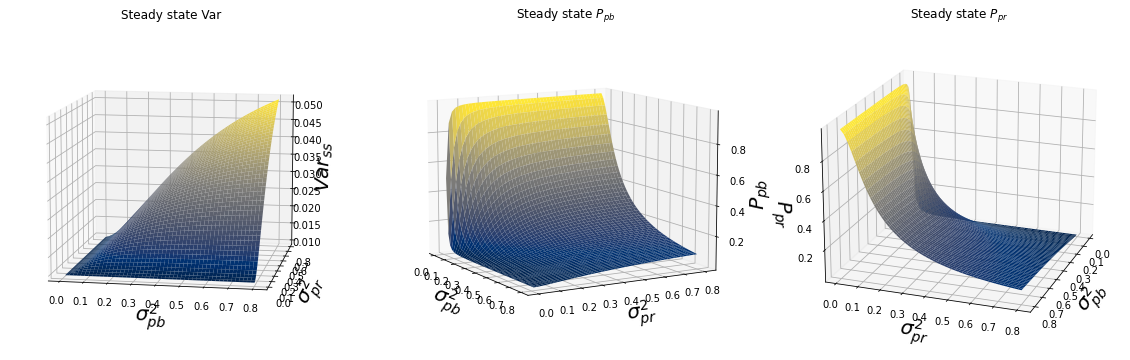

In [38]:
if __name__ == "__main__":
    
    ## plot steady state vars and Kalman gains
    
    import matplotlib.pyplot as plt 
    sigma_pb_ = np.linspace(0.01, 0.8, 50)
    sigma_pr_ = np.linspace(0.01, 0.8, 50)
    
    rho,sigma = 0.98,0.1
    sigma_pbs,sigma_prs = np.meshgrid(sigma_pb_,sigma_pr_)
    
    ss_vars = SteadyStateVar(np.array([rho,
                                       sigma]
                                     ),
                             [sigma_pbs,
                              sigma_prs]
                            )
    ## get Kalman gains as well   
    
    row,col  = ss_vars.shape
    pkalmans = []
    
    for i in range(row):
        for j in range(col):
            pkalman_this = Pkalman(np.array([rho,
                                       sigma]),
                                    np.array([sigma_pbs[i,j],
                                              sigma_prs[i,j]]),
                                    ss_vars[i,j]
                                   )
            pkalmans.append(pkalman_this)
    
    pkalmans_pb = np.array([pkalman[0] for pkalman in pkalmans]).reshape((row,col))
    pkalmans_pr = np.array([pkalman[1] for pkalman in pkalmans]).reshape((row,col))
    
    
    ## plot 
    #####################
    ## figure 1
    #####################
    
    fig = plt.figure(figsize = (20,10))
    #fig.colorbar(surf)
    
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.set_title('Steady state Var')
    surf = ax.plot_surface(sigma_pbs, 
                           sigma_prs, 
                           ss_vars, 
                           cmap = plt.cm.cividis)

    # Set axes label
    ax.set_xlabel(r'$\sigma_{pb}$',size=20)
    ax.set_ylabel('$\sigma_{pr}$',size=20)
    ax.set_zlabel(r'$Var_{ss}$',size=20)
    ax.view_init(elev=10,
                 azim=-80)
    #####################
    ## figure 2
    #####################
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    
    ax2.set_title(r'Steady state $P_{pb}$')
    surf = ax2.plot_surface(sigma_pbs, 
                           sigma_prs, 
                           pkalmans_pb, 
                           cmap = plt.cm.cividis)

    # Set axes label
   
    ax2.set_xlabel(r'$\sigma_{pb}$',size=20)
    ax2.set_ylabel('$\sigma_{pr}$',size=20)
    ax2.set_zlabel(r'$P_{pb}$',size=20)
    ax2.view_init(elev=10,
                 azim=-30)
    
    #####################
    ## figure 3
    #####################
    ax3 = fig.add_subplot(1, 
                          3, 
                          3, 
                          projection='3d')
    
    ax3.set_title(r'Steady state $P_{pr}$')
    surf = ax3.plot_surface(sigma_pbs, 
                           sigma_prs, 
                           pkalmans_pr, 
                           cmap = plt.cm.cividis)

    # Set axes label
   
    ax3.set_xlabel(r'$\sigma_{pb}$',size=20)
    ax3.set_ylabel('$\sigma_{pr}$',size=20)
    ax3.set_zlabel(r'$P_{pr}$',size=20)
    ax3.view_init(elev=20,
                 azim=20)

In [39]:
@jitclass(model_data)
class NoisyInformationAR:
    def __init__(self,
                 exp_para,
                 process_para,
                 real_time,
                 history,
                 horizon = 1):
        self.exp_para = exp_para
        self.process_para = process_para
        if process_para[0] >1:
            print("Warning:persistent parameter cannot be more than 1")
            self.process_para[0] = 1.0
        self.horizon = horizon
        self.real_time = real_time
        self.history = history

    def GetRealization(self,
                       realized_series):
        self.realized = realized_series
        
    def SimForecasts(self,
                     n_sim = 500):
        ## inputs 
        
        real_time = self.real_time
        history = self.history
        realized = self.realized
        n = len(real_time)
        n_history = len(history)
        n_burn = len(history) - n
        
        ## parameters 
        ρ,σ = self.process_para
        sigma_pb,sigma_pr = self.exp_para

        #######################
        ## using uncertainty at steady state of the Kalman filtering
        var_init = SteadyStateVar(self.process_para,
                                  self.exp_para)    ## some initial level of uncertainty, will be washed out after long simulation
        ##################
        sigma_v = np.array([[sigma_pb**2,0.0],
                            [0.0,sigma_pr**2]]) ## variance matrix of signal noises 
        horizon = self.horizon      
        
        ## simulate signals 
        nb_s = 2                                    ## the number of signals 
        H = np.array([[1.0],[1.0]])                 ## an multiplicative matrix summing all signals
        
        # randomly simulated signals 
        np.random.seed(12434)
        signal_pb = self.history+sigma_pb*np.random.randn(n_history)   ## one series of public signals 
        signals_pb = signal_pb.repeat(n_sim).reshape((-1,n_sim)).T     ## shared by all agents
        np.random.seed(13435)
        signals_pr = self.history + sigma_pr*np.random.randn(n_sim*n_history).reshape((n_sim,n_history))
                                                                 ### private signals are agent-specific 
    
        ## prepare matrices 
        nowcasts_to_burn = np.zeros((n_sim,n_history))  ### nowcasts matrix of which the initial simulation is to be burned 
        nowcasts_to_burn[:,0] = history[0]
        nowvars_to_burn = np.zeros((n_sim,n_history))   ### nowcasts uncertainty matrix
        nowvars_to_burn[:,0] = var_init
        Vars_to_burn = np.zeros((n_sim,n_history))      ### forecasting uncertainty matrix 
        
        
        ## fill the matrices for individual moments        
        for i in range(n_sim):
            signals_this_i = np.concatenate((signals_pb[i,:],
                                             signals_pr[i,:]),
                                            axis=0).reshape((2,-1))
            ## the histories signals specific to i: the first row is public signals and the second is private signals 
            Pkalman = np.zeros((n_history,nb_s))
            ## Kalman gains of this agent for respective signals 
            Pkalman[0,:] = 0  ## some initial values 
            
            for t in range(n_history-1):
                step1_vars_to_burn = ρ**2*nowvars_to_burn[i,t] + σ**2
                ## prior uncertainty 
                
                inv = np.linalg.inv(H*step1_vars_to_burn*H.T+sigma_v) 
                ## the inverse of the noisiness matrix  
                
                inv_sc = np.dot(np.dot(H.T,inv),H)
                ## the total noisiness as a scalar 
                
                var_reduc = step1_vars_to_burn*inv_sc*step1_vars_to_burn
                ## reduction in uncertainty from the update
                
                nowvars_this_2d = np.array([[step1_vars_to_burn]]) - var_reduc
                ## update equation of nowcasting uncertainty 
                
                nowvars_to_burn[i,t+1] = nowvars_this_2d[0,0] 
                ## nowvars_this_2d is a 2-d matrix with only one entry. We take the element and set it to the matrix
                ### this is necessary for Numba typing 
                
                Pkalman[t+1,:] = step1_vars_to_burn*np.dot(H.T,np.linalg.inv(H*step1_vars_to_burn*H.T+sigma_v))
                ## update Kalman gains recursively using the signal extraction ratios 
                
                Pkalman_all = np.dot(Pkalman[t+1,:],H)[0]  
                ## the weight to the prior forecast 
    
                nowcasts_to_burn[i,t+1] = (1-Pkalman_all)*ρ*nowcasts_to_burn[i,t]+ np.dot(Pkalman[t+1,:],
                                                                                          signals_this_i[:,t+1])
                ## kalman filtering updating for nowcasting: weighted average of prior and signals 
                
            for t in range(n_history):
                Vars_to_burn[i,t] = ρ**(2*horizon)*nowvars_to_burn[i,t] + hstepvar(horizon,
                                                                                   ρ,
                                                                                   σ)
                
        nowcasts = nowcasts_to_burn[:,n_burn:]
        forecasts = ρ**horizon*nowcasts 
        Vars = Vars_to_burn[:,n_burn:]
        
        ## compute population moments
        forecasts_mean = np_mean(forecasts,axis=0)
        forecasts_var = np_var(forecasts,axis=0)
        FEs_mean = forecasts_mean - realized
            
        Vars_mean = np_mean(Vars,
                            axis=0) ## need to change for time-variant volatility
        
        forecast_moments_sim = {"Forecast":forecasts_mean,
                                "FE":FEs_mean,
                                "Disg":forecasts_var,
                                "Var":Vars_mean}
        return forecast_moments_sim
    
    def SMM(self):
        
        ρ,σ = self.process_para
        horizon = self.horizon
        #################################
        # inflation moments 
        #################################

        InfAV  = 0.0
        if ρ <1.0:
            InfVar = σ**2/(1-ρ**2)
        else:
            Infvar = np.inf
        InfATV = ρ**horizon*InfVar
        
        #################################
        # expectation moments 
        #################################
        ## simulate forecasts
        moms_sim = self.SimForecasts()
        Forecasts_sim = moms_sim['Forecast']
        FEs_sim = moms_sim['FE']
        Disgs_sim = moms_sim['Disg']
        Vars_sim = moms_sim['Var']
        
        ## SMM moments    
        Forecast_sim = np.mean(Forecasts_sim)
        FE_sim = np.mean(FEs_sim)
        FEVar_sim = np.var(FEs_sim)
        FEATV_sim = np.cov(np.stack( (FEs_sim[horizon:],FEs_sim[:-horizon]),axis = 0 ))[0,1]
        Disg_sim = np.mean(Disgs_sim)
        DisgVar_sim = np.var(Disgs_sim)
        DisgATV_sim = np.cov(np.stack( (Disgs_sim[horizon:],Disgs_sim[:-horizon]),axis = 0))[0,1]
        
        Var_sim = np.mean(Vars_sim)
        VarVar_sim = np.var(Vars_sim)
        VarATV_sim = np.cov(np.stack( (Vars_sim[horizon:],Vars_sim[:-horizon]),axis = 0))[0,1]
    
        SMMMoments = {"InfAV":InfAV,
                      "InfVar":InfVar,
                      "InfATV":InfATV,
                      "Forecast":Forecast_sim,
                      "FE":FE_sim,
                      "FEVar":FEVar_sim,
                      "FEATV":FEATV_sim,
                      "Disg":Disg_sim,
                      "DisgVar":DisgVar_sim,
                      "DisgATV":DisgATV_sim,
                      "Var":Var_sim,
                      'VarVar':VarVar_sim,
                      'VarATV':VarATV_sim}
        return SMMMoments
    
    
    def GMM(self):
        ρ,σ = self.process_para
        horizon = self.horizon
        sigma_pb,sigma_pr = self.exp_para
        
        ## some middle steps for moments below 
        var_ss_now =  SteadyStateVar(self.process_para,
                                    self.exp_para) ## steady state nowcasting uncertainty 
        cum_fe2_sum = np.sum(np.array([ρ**(2*k)*σ**2 for k in range(horizon)])) ##fire forecast errors 
        P_ss = Pkalman(self.process_para,
                      self.exp_para,
                      var_ss_now)
        fevar_num = ρ**(2*horizon)*P_ss[0]**2*sigma_pb**2+cum_fe2_sum
        fevar_dem = (P_ss[0]+P_ss[1])**2
        fevar = fevar_num/fevar_dem
        GMMMoments = {"InfAV":0.0,
                     "InfVar":σ**2/(1-ρ**2),
                      "InfATV":ρ*σ**2/(1-ρ**2),
                      "Forecasts":0.0,
                      "FE":0.0,
                      "FEVar":fevar,  
                      "FEATV":(1-P_ss[0]-P_ss[1])*ρ*fevar,
                      "Disg":np.nan,
                      "DisgVar":np.nan,
                      "DisgATV":np.nan,
                      "Var":ρ**(2*horizon)*var_ss_now+cum_fe2_sum,
                      'VarVar':np.nan,
                      'VarATV':np.nan
                     }
        
        return GMMMoments

In [40]:
if __name__ == "__main__":
    ni_exp_para_fake = np.array([0.1,0.2])
    ## initialize the ar instance 
    niar0 = NoisyInformationAR(exp_para = ni_exp_para_fake,
                                process_para = np.array([ρ0,σ0]),
                                real_time = real_time0,
                                history = history0,
                                horizon = 1)

    niar0.GetRealization(realized0)

#### Estimating NI using RE data 

- The example below shows that NIAR seems to almost albeit imperfectly to identify sigma_pr and sigma_pb to be zero if rational expectation moments are used. 

In [41]:
if __name__ == "__main__":


    moments0 = [#'FE',
                'FEATV',
                'FEVar',
                'Disg',
                #'DisgATV',
                #'DisgVar',
                'Var',
                #'VarVar',
                #'VarATV'
               ]

    def Objniar_re(paras):
        scalor = ObjGen(niar0,
                        paras = paras,
                        data_mom_dict = data_mom_dict_re,
                        moment_choice = moments0,
                        how = 'expectation')
        return scalor

    ## invoke estimation 
    Est = ParaEst(Objniar_re,
            para_guess = np.array([0.1,0.1]),
            method='trust-constr',
           bounds=((0,None),(0,None),))
    
    print('True parameters: ',str(np.array([0.0,0.0]))) ## rational expectations 
    print('Estimates: ',str(Est))

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_82986/2685684584.py:32: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  model_mom_dict = model.SMM()
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'moment_choice' of function 'ObjGen'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_82986/2685684584.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 54, CG iterations: 19, optimality: 7.21e-09, constraint violation: 0.00e+00, execution time: 2.1e+01 s.
True parameters:  [0. 0.]
Estimates:  [0.14242093 0.00095991]


#### Estimate NI with NI

- The example below shows that NIAR SMM correctly identifies the noisiness of both private and public signals using fake moments with known parameters. 

In [42]:
if __name__ == "__main__":


    ## get a fake data moment dictionary under a different parameter 
    exp_paras_fake = np.array([0.1,0.08])
    niar1 = NoisyInformationAR(exp_para = exp_paras_fake,
                                process_para = np.array([ρ0,σ0]),
                                real_time = real_time0,
                                history = history0,
                                horizon = 1)

    niar1.GetRealization(realized0)

    data_mom_dict_ni = niar1.SMM()

    moments0 = ['FE',
                'FEVar',
                'FEATV',
                'Disg',
                'DisgVar',
                'Var']

    def Objniar_ni(paras):
        scalor = ObjGen(niar0,
                        paras = paras,
                        data_mom_dict = data_mom_dict_ni,
                        moment_choice = moments0,
                        how = 'expectation')
        return scalor

    ## invoke estimation 

    Est = ParaEst(Objniar_ni,
            para_guess = np.array([0.2,0.3]),
            method='trust-constr',  # see to work for both L-BFGS-B and Nelder-Mead
            bounds = ((0,None),(0,None),)
           )
    print('True parameters: ',str(exp_paras_fake)) ## rational expectations 
    print('Estimates: ',str(Est))

`xtol` termination condition is satisfied.
Number of iterations: 147, function evaluations: 441, CG iterations: 166, optimality: 9.21e-05, constraint violation: 0.00e+00, execution time: 1.8e+02 s.
True parameters:  [0.1  0.08]
Estimates:  [0.10000029 0.07999998]


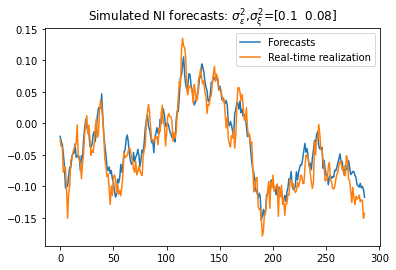

In [43]:
if __name__ == "__main__":
    ## plot for validation 
    simulated_niar  = niar1.SimForecasts()
    plt.title(r"Simulated NI forecasts: $\sigma^2_\epsilon$,$\sigma^2_\xi$={}".format(exp_paras_fake))
    plt.plot(simulated_niar['Forecast'],
             label='Forecasts')
    plt.plot(niar1.real_time,
             label='Real-time realization')
    plt.legend(loc=0)

#### Joint Estimation

In [44]:
if __name__ == "__main__":


    ## for joint estimation 

    moments1 = ['InfAV',
                'InfVar',
                'InfATV',
                'FE',
                'FEVar',
                'FEATV',
                'Disg',
               'DisgVar',
               'DisgATV',
               'Var',
               'VarVar',
               'VarATV']

    def Objniar_joint(paras):
        scalar = ObjGen(niar0,
                        paras = paras,
                        data_mom_dict = data_mom_dict_ni,
                        moment_choice = moments1,
                        how ='joint',
                        n_exp_paras = 2)
        return scalar

    ## invoke estimation 
    Est = ParaEst(Objniar_joint,
            para_guess = np.array([0.2,0.3,0.8,0.2]),
            method='trust-constr'
           )
    
    print('True process parameters: ',str(np.array([ρ0,σ0])))
    print('Estimates: ',str(Est[2:]))
    print('True expectation parameter',str(exp_paras_fake))  
    print('Estimates: ',str(Est[0:2]))

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'moment_choice' of function 'ObjGen'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_82986/2685684584.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`xtol` termination condition is satisfied.
Number of iterations: 192, function evaluations: 960, CG iterations: 444, optimality: 1.93e-02, constraint violation: 0.00e+00, execution time: 3.9e+02 s.
True process parameters:  [0.98 0.02]
Estimates:  [0.98000597 0.01999701]
True expectation parameter [0.1  0.08]
Estimates:  [0.10004131 0.08000154]


In [45]:
if __name__ == "__main__":

    ## check if simulated moments and computed moments match 
    data_mom_dict_ni_computed = niar1.GMM()
    
    print("Simulated moments:",data_mom_dict_ni)
    print('\n')
    print("Computed moments:",data_mom_dict_ni_computed)

Simulated moments: {InfAV: 0.0, InfVar: 0.010101010101010081, InfATV: 0.00989898989898988, Forecast: -0.03551522800390356, FE: 0.007073492234424343, FEVar: 0.00038722505751580873, FEATV: 0.00019890825387490612, Disg: 0.00032862250192003585, DisgVar: 4.4379245356028884e-10, DisgATV: 2.1649865320515735e-10, Var: 0.001378135803212879, VarVar: 8.157895425833552e-18, VarATV: 4.308808287811099e-18}


Computed moments: {InfAV: 0.0, InfVar: 0.010101010101010081, InfATV: 0.00989898989898988, Forecasts: 0.0, FE: 0.0, FEVar: 0.006302591176962443, FEATV: 0.004400908235689559, Disg: nan, DisgVar: nan, DisgATV: nan, Var: 0.0015745141220104724, VarVar: nan, VarATV: nan}


### Noisy Information (NI) + SV



In [46]:
@jitclass(model_sv_data)
class NoisyInformationSV:
    def __init__(self,
                 exp_para,
                 process_para,
                 real_time,
                 history,
                 horizon = 1):
        self.exp_para = exp_para
        self.process_para = process_para
        self.horizon = horizon
        self.real_time = real_time
        self.history = history

    def GetRealization(self,
                       realized_series):
        self.realized = realized_series
              
    def SimForecasts(self,
                     n_sim = 500):
        ## inputs 
        real_time = self.real_time
        history  = self.history
        n = len(real_time[0,:])
        horizon = self.horizon
        n_history = len(history[0,:]) # of course equal to len(history)
        n_burn = n_history - n
        
        ## get the information set 
        infoset = history 
        y_now, p_now, sigmas_p_now, sigmas_t_now= infoset[0,:],infoset[1,:],infoset[2,:],infoset[3,:]
        sigmas_now = np.concatenate((sigmas_p_now,sigmas_t_now),axis=0).reshape((2,-1))
        
        ## process parameters
        γ = self.process_para
        ## exp parameters 
        sigma_pb,sigma_pr = self.exp_para
        var_init = sigmas_now[0,0]**2+sigmas_now[1,0]**2
        
        ## other parameters 
        sigma_v = np.array([[sigma_pb**2,0.0],[0.0,sigma_pr**2]]) ## variance matrix of signal noises         
        ## simulate signals 
        nb_s = 2                                    ## the number of signals 
        H = np.array([[1.0],[1.0]])                 ## a multiplicative matrix summing all signals
        
        # randomly simulated signals 
        np.random.seed(12434)
        ##########################################################
        signal_pb = p_now+sigma_pb*np.random.randn(n_history)   ## one series of public signals 
        signals_pb = signal_pb.repeat(n_sim).reshape((-1,n_sim)).T     ## shared by all agents
        np.random.seed(13435)
        signals_pr = p_now + sigma_pr*np.random.randn(n_sim*n_history).reshape((n_sim,n_history))
        #####################################################################################

        ## prepare matrices 
        nowcasts_to_burn = np.zeros((n_sim,n_history))
        nowcasts_to_burn[:,0] = p_now[0]
        nowvars_to_burn = np.zeros((n_sim,n_history))
        nowvars_to_burn[:,0] = var_init
        Vars_to_burn = np.zeros((n_sim,n_history))
        
        ## fill the matricies for individual moments        
        for i in range(n_sim):
            signals_this_i = np.concatenate((signals_pb[i,:],signals_pr[i,:]),axis=0).reshape((2,-1))
            ## the histories signals specific to i: the first row is public signals and the second is private signals 
            Pkalman = np.zeros((n_history,nb_s))
            ## Kalman gains of this agent for respective signals 
            Pkalman[0,:] = 0  ## some initial values 
            
            for t in range(n_history-1):
                step1var = hstepvarSV(1,
                                      sigmas_now[:,t],
                                      γ[0])
                step1_vars_to_burn = nowvars_to_burn[i,t] + step1var
                ## prior uncertainty 
                
                inv = np.linalg.inv(H*step1_vars_to_burn*H.T+sigma_v) 
                ## the inverse of the noisiness matrix  
                
                inv_sc = np.dot(np.dot(H.T,inv),H)
                ## the total noisiness as a scalar 
                
                var_reduc = step1_vars_to_burn*inv_sc*step1_vars_to_burn
                ## reduction in uncertainty from the update
                
                nowvars_this_2d = np.array([[step1_vars_to_burn]]) - var_reduc
                ## update equation of nowcasting uncertainty 
                
                nowvars_to_burn[i,t+1] = nowvars_this_2d[0,0] 
                ## nowvars_this_2d is a 2-d matrix with only one entry. We take the element and set it to the matrix
                ### this is necessary for Numba typing 
                
                Pkalman[t+1,:] = step1_vars_to_burn*np.dot(H.T,np.linalg.inv(H*step1_vars_to_burn*H.T+sigma_v))
                ## update Kalman gains recursively using the signal extraction ratios 
                
                Pkalman_all = np.dot(Pkalman[t+1,:],H)[0] 
                ## the weight to the prior forecast 
    
                nowcasts_to_burn[i,t+1] = (1-Pkalman_all)*nowcasts_to_burn[i,t]+ np.dot(Pkalman[t+1,:],signals_this_i[:,t+1])
                ## kalman filtering updating for nowcasting: weighted average of prior and signals 
                
            for t in range(n_history):
                stephvar = hstepvarSV(horizon,
                                      sigmas_now[:,t],
                                      γ[0])
                Vars_to_burn[i,t] = nowvars_to_burn[i,t] + stephvar
                
        nowcasts = nowcasts_to_burn[:,n_burn:]
        forecasts = nowcasts 
        Vars = Vars_to_burn[:,n_burn:]

        
        ## compute population moments
        forecasts_mean = np_mean(forecasts,axis=0)
        forecasts_var = np_var(forecasts,axis=0)
        FEs_mean = forecasts_mean - self.realized
        Vars_mean = np_mean(Vars,axis=0) ## need to change for time-variant volatility
        
        forecast_moments_sim = {"Forecast":forecasts_mean,
                                "FE":FEs_mean,
                                "Disg":forecasts_var,
                                "Var":Vars_mean}
        return forecast_moments_sim
        
    def SMM(self):
        
        γ = self.process_para
        horizon = self.horizon
        #################################
        # inflation moments 
        #################################

        InfAV  = np.nan
        InfVar = np.nan
        InfATV = np.nan
        
        #################################
        # expectation moments 
        #################################
        ## simulate forecasts
        moms_sim = self.SimForecasts()
        Forecasts_sim = moms_sim['Forecast']
        FEs_sim = moms_sim['FE']
        Disgs_sim = moms_sim['Disg']
        Vars_sim = moms_sim['Var']
        
        ## SMM moments
        Forecast_sim = np.mean(Forecasts_sim)
        FE_sim = np.mean(FEs_sim)
        FEVar_sim = np.var(FEs_sim)
        FEATV_sim = np.cov(np.stack( (FEs_sim[horizon:],FEs_sim[:-horizon]),axis = 0 ))[0,1]
        Disg_sim = np.mean(Disgs_sim)
        DisgVar_sim = np.var(Disgs_sim)
        DisgATV_sim = np.cov(np.stack( (Disgs_sim[horizon:],Disgs_sim[:-horizon]),axis = 0))[0,1]
        
        Var_sim = np.mean(Vars_sim)
        VarVar_sim = np.var(Vars_sim)
        VarATV_sim = np.cov(np.stack( (Vars_sim[horizon:],Vars_sim[:-horizon]),axis = 0))[0,1]
    
        SMMMoments = {"InfAV":InfAV,
                      "InfVar":InfVar,
                      "InfATV":InfATV,
                      "Forecast":Forecast_sim,
                      "FE":FE_sim,
                      "FEVar":FEVar_sim,
                      "FEATV":FEATV_sim,
                      "Disg":Disg_sim,
                      "DisgVar":DisgVar_sim,
                      "DisgATV":DisgATV_sim,
                      "Var":Var_sim,
                      'VarVar':VarVar_sim,
                      'VarATV':VarATV_sim}
        return SMMMoments

In [47]:
if __name__ == "__main__":

    ## initial a sv instance
    nisv0 = NoisyInformationSV(exp_para = np.array([0.3,0.2]),
                               process_para = np.array([0.1]),
                               real_time = xx_real_time,
                               history = xx_real_time) ## history does not matter here, 

    ## get the realization 

    nisv0.GetRealization(xx_realized)

###  Diagnostic Expectation(DE) + AR1

In [137]:
@jitclass(model_data)
class DiagnosticExpectationAR:
    def __init__(self,
                 exp_para,
                 process_para,
                 real_time,
                 history,
                 horizon = 1):
        self.exp_para = exp_para
        self.process_para = process_para
        if process_para[0] >1:
            print("Warning:persistent parameter cannot be more than 1")
            self.process_para[0] = 1.0
        self.horizon = horizon
        self.real_time = real_time
        self.history = history

    def GetRealization(self,
                       realized_series):
        self.realized = realized_series
        
    def SimForecasts(self,
                     n_sim = 500):
        ## inputs 
        real_time = self.real_time
        history  = self.history
        realized = self.realized
        n = len(real_time)
        horizon = self.horizon 
        n_burn = len(history) - n
        n_history = len(history)  # of course equal to len(history)
        
        ## parameters 
        ρ,σ = self.process_para
        theta,theta_sigma = self.exp_para
        
    
        ## simulation
        np.random.seed(12345)
        thetas = theta_sigma*np.random.randn(n_sim) + theta  ## randomly drawn representativeness parameters
        
        nowcasts_to_burn = np.empty((n_sim,n_history))
        Vars_to_burn = np.empty((n_sim,n_history))
        nowcasts_to_burn[:,0] = history[0]
        Vars_to_burn[:,:] = hstepvar(horizon,ρ,σ)
        
        ## diagnostic and extrapolative expectations 
        for i in range(n_sim):
            this_theta = thetas[i]
            for j in range(n_history-1):
                nowcasts_to_burn[i,j+1] = history[j+1]+ this_theta*(history[j+1]-ρ*history[j])  # can be nowcasting[j-1] instead
        
        ## burn initial forecasts since history is too short 
        nowcasts = nowcasts_to_burn[:,n_burn:]
        forecasts = ρ**horizon*nowcasts
        Vars = Vars_to_burn[:,n_burn:]
        
        FEs = forecasts - realized
        
        ## compute population moments
        forecasts_mean = np_mean(forecasts,axis = 0)
        forecasts_var = np_var(forecasts,axis = 0)
        FEs_mean = forecasts_mean - realized  
        Vars_mean = np_mean(Vars,axis = 0) ## need to change 
        
        #forecasts_vcv = np.cov(forecasts.T)
        #forecasts_atv = np.array([forecasts_vcv[i+1,i] for i in range(n-1)])
        #FEs_vcv = np.cov(FEs.T)
        
        forecast_moments_sim = {"Forecast":forecasts_mean,
                                "FE":FEs_mean,
                                "Disg":forecasts_var,
                                "Var":Vars_mean}
        return forecast_moments_sim
    
    def SMM(self):
        
        ρ,σ = self.process_para
        horizon = self.horizon
        #################################
        # inflation moments 
        #################################

        InfAV  = 0.0
        if ρ <1.0:
            InfVar = σ**2/(1-ρ**2)
        else:
            Infvar = np.inf
        InfATV = ρ**horizon*InfVar
        
        #################################
        # expectation moments 
        #################################
        ## simulate forecasts
        moms_sim = self.SimForecasts()
        Forecasts_sim = moms_sim['Forecast']
        FEs_sim = moms_sim['FE']
        Disgs_sim = moms_sim['Disg']
        Vars_sim = moms_sim['Var']
        
        ## SMM moments   
        Forecast_sim = np.mean(Forecasts_sim)
        FE_sim = np.mean(FEs_sim)
        FEVar_sim = np.var(FEs_sim)
        FEATV_sim = np.cov(np.stack( (FEs_sim[horizon:],FEs_sim[:-horizon]),axis = 0 ))[0,1]
        Disg_sim = np.mean(Disgs_sim)
        DisgVar_sim = np.var(Disgs_sim)
        DisgATV_sim = np.cov(np.stack( (Disgs_sim[horizon:],Disgs_sim[:-horizon]),axis = 0))[0,1]
        
        Var_sim = np.mean(Vars_sim)
        VarVar_sim = np.var(Vars_sim)
        VarATV_sim = np.cov(np.stack( (Vars_sim[horizon:],Vars_sim[:-horizon]),axis = 0))[0,1]
    
        SMMMoments = {"InfAV":InfAV,
                      "InfVar":InfVar,
                      "InfATV":InfATV,
                      "Forecast":Forecast_sim,
                      "FE":FE_sim,
                      "FEVar":FEVar_sim,
                      "FEATV":FEATV_sim,
                      "Disg":Disg_sim,
                      "DisgVar":DisgVar_sim,
                      "DisgATV":DisgATV_sim,
                      "Var":Var_sim,
                      'VarVar':VarVar_sim,
                      'VarATV':VarATV_sim}
        return SMMMoments
    
    def GMM(self):
        ρ,σ = self.process_para
        horizon = self.horizon
        theta,theta_sigma = self.exp_para
        
        ## some middle steps for moments below 
        
        GMMMoments = {"InfAV":0.0,
                     "InfVar":σ**2/(1-ρ**2),
                      "InfATV":ρ*σ**2/(1-ρ**2),
                     "Forecasts":0.0,
                      "FE":0.0,
                      "FEVar":1/(1-theta**2*ρ**2)*sum([ρ**(2*k)*σ**2 for k in range(horizon)]),  
                      "FEATV":-theta*ρ*σ**2/(1-theta**2*ρ**2),
                      "Disg":np.nan,
                      "DisgVar":np.nan,
                      "DisgATV":np.nan,
                      "Var":sum([ρ**k*σ**2 for k in range(horizon)]),
                      'VarVar':np.nan,
                      'VarATV':np.nan
                     }
        
        return GMMMoments

In [138]:
if __name__ == "__main__":


    ## initialize the ar instance 
    dear0 = DiagnosticExpectationAR(exp_para = np.array([0.5,0.2]),
                                    process_para = np.array([ρ0,σ0]),
                                    real_time = real_time0,
                                    history = history0,
                                    horizon = 1)

    dear0.GetRealization(realized0)

#### Estimating DE using RE data

- The example below shows that DEAR SMM approximately identifies the parameters of overreaction to be zero and zero-dispersion using rational expectation forecast moments.  

In [145]:
if __name__ == "__main__":


    ## only expectation estimation 

    moments0 = [#'FE',
                'FEVar',
                #'FEATV',
                'Disg',
                'Var']

    def Objdear_re(paras):
        scalar = ObjGen(dear0,
                        paras = paras,
                        data_mom_dict = data_mom_dict_re,
                        moment_choice = moments0,
                        how = 'expectation')
        return scalar


    ## invoke estimation 
    Est = ParaEst(Objdear_re,
           para_guess = np.array([0.2,0.3]),
            method='trust-constr')
    
    print('True parameters: ',str(np.array([0.0,0.0]))) ## rational expectations 
    print('Estimates: ',str(Est))

`xtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 144, CG iterations: 55, optimality: 5.43e-06, constraint violation: 0.00e+00, execution time: 0.18 s.
True parameters:  [0. 0.]
Estimates:  [0.01015938 0.00147958]


#### Estimating DE using DE data 

In [150]:
if __name__ == "__main__":


    ## get a fake data moment dictionary under a different parameter 
    de_exp_paras_fake = np.array([0.3,0.1])
    dear1 = DiagnosticExpectationAR(exp_para = de_exp_paras_fake,
                                    process_para = np.array([ρ0,σ0]),
                                    real_time = real_time0,
                                    history = history0,
                                    horizon = 1)

    dear1.GetRealization(realized0)

    data_mom_dict_de = dear1.SMM()


    ## only expectation estimation 

    moments0 = ['FE',
                'FEVar',
                'FEATV',
                'Disg',
                'DisgVar',
                'Var']

    def Objdear_de(paras):
        scalar = ObjGen(dear0,
                        paras = paras,
                        data_mom_dict = data_mom_dict_de,
                        moment_choice = moments0,
                        how = 'expectation')
        return scalar


    ## invoke estimation 
    Est = ParaEst(Objdear_de,
                  para_guess = np.array([0.2,0.3]),
                  method='trust-constr')
    
    print('True parameters: ',str(exp_paras_fake)) 
    print('Estimates: ',str(Est))

`gtol` termination condition is satisfied.
Number of iterations: 28, function evaluations: 84, CG iterations: 31, optimality: 9.39e-10, constraint violation: 0.00e+00, execution time: 0.13 s.
True parameters:  [0.3 0.1]
Estimates:  [0.30005843 0.09999905]


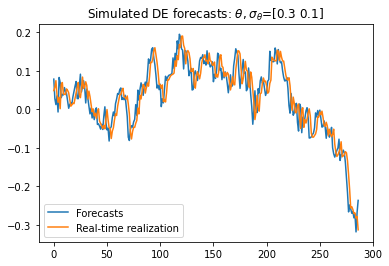

In [152]:
if __name__ == "__main__":
    ## plot for validation 
    simulated_dear  = dear1.SimForecasts()
    plt.title(r"Simulated DE forecasts: $\theta,\sigma_\theta$={}".format(de_exp_paras_fake))
    plt.plot(simulated_dear['Forecast'],label='Forecasts')
    plt.plot(dear1.real_time,label='Real-time realization')
    plt.legend(loc=0)

#### Joint Estimation 

In [176]:
if __name__ == "__main__":

    ## for joint estimation 
    moments1 = [#'InfAV',
                'InfVar',
                'InfATV',
                'FE',
                'FEVar',
                'FEATV',
                'Disg',
               'Var']

    def Objdear_joint(paras):
        scalar = ObjGen(dear0,
                        paras = paras,
                        data_mom_dict = data_mom_dict_de,
                        moment_choice = moments1,
                        how ='joint',
                        n_exp_paras = 2)
        return scalar

    ## invoke estimation 
    Est = ParaEst(Objdear_joint,
            para_guess = np.array([0.2,0.4,0.4,0.05]),
            method='trust-constr')
    
    print('True process parameters: ',str(np.array([ρ0,σ0])))
    print('Estimates: ',str(Est[2:]))
    print('True expectation parameter',str(exp_paras_fake))  
    print('Estimates: ',str(Est[0:2]))

`xtol` termination condition is satisfied.
Number of iterations: 97, function evaluations: 485, CG iterations: 172, optimality: 4.85e-03, constraint violation: 0.00e+00, execution time: 0.52 s.
True process parameters:  [0.98 0.02]
Estimates:  [0.98001396 0.01999303]
True expectation parameter [0.3 0.1]
Estimates:  [0.30152392 0.12752602]


In [177]:
if __name__ == "__main__":

    ## check if simulated moments and computed moments match 
    data_mom_dict_de_computed = dear1.GMM()
    
    print("Simulated moments:",data_mom_dict_de)
    print('\n')
    print("Computed moments:",data_mom_dict_de_computed)

Simulated moments: {InfAV: 0.0, InfVar: 0.010101010101010081, InfATV: 0.00989898989898988, Forecast: 0.02854222801022335, FE: -0.0017843105426854258, FEVar: 0.0007152436664556466, FEATV: 3.86212595847211e-05, Disg: 4.335945347041773e-06, DisgVar: 3.72179283063778e-11, DisgATV: -8.674611954765011e-13, Var: 0.00040000000000000116, VarVar: 4.243534606468458e-36, VarATV: 4.2584242015788734e-36}


Computed moments: {InfAV: 0.0, InfVar: 0.010101010101010081, InfATV: 0.00989898989898988, Forecasts: 0.0, FE: 0.0, FEVar: 0.00043784562438975265, FEATV: -0.00012872661357058728, Disg: nan, DisgVar: nan, DisgATV: nan, Var: 0.0004, VarVar: nan, VarATV: nan}


###  Diagnostic Expectation(DE) + SV

In [178]:
@jitclass(model_sv_data)
class DiagnosticExpectationSV:
    def __init__(self,
                 exp_para,
                 process_para,
                 real_time,
                 history,
                 horizon = 1):
        self.exp_para = exp_para
        self.process_para = process_para
        self.horizon = horizon
        self.real_time = real_time
        self.history = history

    def GetRealization(self,
                       realized_series):
        self.realized = realized_series
        
    def SimForecasts(self,
                     n_sim = 500):
        ## inputs 
        real_time = self.real_time
        history  = self.history
        realized = self.realized
        n = len(real_time[0,:])
        horizon = self.horizon
        n_history = len(history[0,:]) # of course equal to len(history)
        n_burn = n_history - n
        
        
        ## get the information set 
        infoset = history 
        y_now, p_now, sigmas_p_now, sigmas_t_now= infoset[0,:],infoset[1,:],infoset[2,:],infoset[3,:]
        sigmas_now = np.concatenate((sigmas_p_now,sigmas_t_now),axis=0).reshape((2,-1))
        
        ## process parameters
        γ = self.process_para
        ## exp parameters 
        theta,theta_sigma= self.exp_para
        
    
        ## simulation of representativeness parameters 
        np.random.seed(12345)
        thetas = theta_sigma*np.random.randn(n_sim) + theta  ## randomly drawn representativeness parameters
        
        
        ## simulation of individual forecasts     
        nowcasts_to_burn = np.empty((n_sim,n_history))
        nowcasts_to_burn[:,0] = p_now[0]
        
        Vars_to_burn = np.empty((n_sim,n_history))
        Vars_to_burn[:,0] = hstepvarSV(horizon,
                                       sigmas_now[:,0],
                                       γ[0])
        
        for i in range(n_sim):
            this_theta = thetas[i]
            for j in range(n_history-1):
                ###########################################################################################
                nowcasts_to_burn[i,j+1] = y_now[j+1]+ this_theta*(y_now[j+1]- p_now[j])  # can be nowcasting[j-1] instead
                Var_now_re = hstepvarSV(horizon,
                                        sigmas_now[:,j+1],
                                        γ[0])
                Vars_to_burn[i,j+1] = Var_now_re #+ this_theta*(Var_now_re - Vars_to_burn[i,j])
                ######### this line of codes needs to be double checked!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                ##########################################################################################
                
        ## burn initial forecasts since history is too short 
        nowcasts = nowcasts_to_burn[:,n_burn:]
        forecasts = nowcasts
        Vars = Vars_to_burn[:,n_burn:]
        
        ## compute population moments
        forecasts_mean = np_mean(forecasts,axis=0)
        forecasts_var = np_var(forecasts,axis=0)
        FEs_mean = forecasts_mean - realized
        Vars_mean = np_mean(Vars,axis = 0) ## need to change 
        
        forecast_moments_sim = {"Forecast":forecasts_mean,
                                "FE":FEs_mean,
                                "Disg":forecasts_var,
                                "Var":Vars_mean}
        return forecast_moments_sim


    def SMM(self):
        
        γ = self.process_para
        horizon = self.horizon
        #################################
        # inflation moments 
        #################################

        InfAV  = np.nan
        InfVar = np.nan
        InfATV = np.nan
        
        #################################
        # expectation moments 
        #################################
        ## simulate forecasts
        moms_sim = self.SimForecasts()
        Forecasts_sim = moms_sim['Forecast']
        FEs_sim = moms_sim['FE']
        Disgs_sim = moms_sim['Disg']
        Vars_sim = moms_sim['Var']
        
        ## SMM moments     
        Forecast_sim = np.mean(Forecasts_sim)
        FE_sim = np.mean(FEs_sim)
        FEVar_sim = np.var(FEs_sim)
        FEATV_sim = np.cov(np.stack( (FEs_sim[horizon:],FEs_sim[:-horizon]),axis = 0 ))[0,1]
        Disg_sim = np.mean(Disgs_sim)
        DisgVar_sim = np.var(Disgs_sim)
        DisgATV_sim = np.cov(np.stack( (Disgs_sim[horizon:],Disgs_sim[:-horizon]),axis = 0))[0,1]
        
        Var_sim = np.mean(Vars_sim)
        VarVar_sim = np.var(Vars_sim)
        VarATV_sim = np.cov(np.stack( (Vars_sim[horizon:],Vars_sim[:-horizon]),axis = 0))[0,1]
    
        SMMMoments = {"InfAV":InfAV,
                      "InfVar":InfVar,
                      "InfATV":InfATV,
                      "Forecast":Forecast_sim,
                      "FE":FE_sim,
                      "FEVar":FEVar_sim,
                      "FEATV":FEATV_sim,
                      "Disg":Disg_sim,
                      "DisgVar":DisgVar_sim,
                      "DisgATV":DisgATV_sim,
                      "Var":Var_sim,
                      'VarVar':VarVar_sim,
                      'VarATV':VarATV_sim}
        return SMMMoments
    
    
    def GMM(self):
        print('not implemented yet!')
        return None

In [179]:
if __name__ == "__main__":

    ## initial a sv instance
    desv0 = DiagnosticExpectationSV(exp_para = np.array([0.3,0.2]),
                                   process_para = np.array([0.1]),
                                   real_time = xx_real_time,
                                   history = xx_real_time) ## history does not matter here, 

    ## get the realization 

    desv0.GetRealization(xx_realized)

###  Diagnostic Expectation and Noisy Information Hybrid(DENI) + AR1

In [182]:
@jitclass(model_data)
class DENIHybridAR:
    def __init__(self,
                 exp_para,
                 process_para,
                 real_time,
                 history,
                 horizon = 1):
        self.exp_para = exp_para
        self.process_para = process_para
        if process_para[0] >1:
            print("Warning:persistent parameter cannot be more than 1")
            self.process_para[0] = 1.0
        self.horizon = horizon
        self.real_time = real_time
        self.history = history

    def GetRealization(self,
                       realized_series):
        self.realized = realized_series
        
    def SimForecasts(self,
                     n_sim = 500):
        ## inputs 
        
        real_time = self.real_time
        history = self.history
        realized = self.realized
        n = len(real_time)
        n_history = len(history)
        n_burn = len(history) - n
        
        ## parameters 
        ρ,σ = self.process_para
        theta,sigma_pb,sigma_pr = self.exp_para

        #######################
        ## using uncertainty at steady state of the Kalman filtering
        var_init = SteadyStateVar(self.process_para,
                                  self.exp_para[1:])    ## some initial level of uncertainty, will be washed out after long simulation
        ##################
        sigma_v = np.array([[sigma_pb**2,0.0],[0.0,sigma_pr**2]]) ## variance matrix of signal noises 
        horizon = self.horizon      
        
        ## simulate signals 
        nb_s = 2                                    ## the number of signals 
        H = np.array([[1.0],[1.0]])                 ## an multiplicative matrix summing all signals
        
        # randomly simulated signals 
        np.random.seed(12434)
        signal_pb = self.history+sigma_pb*np.random.randn(n_history)   ## one series of public signals 
        signals_pb = signal_pb.repeat(n_sim).reshape((-1,n_sim)).T     ## shared by all agents
        np.random.seed(13435)
        signals_pr = self.history + sigma_pr*np.random.randn(n_sim*n_history).reshape((n_sim,n_history))
                                                                 ### private signals are agent-specific 
    
        ## prepare matrices
        nowcasts_to_burn = np.zeros((n_sim,n_history))  ### nowcasts matrix of which the initial simulation is to be burned 
        nowcasts_to_burn[:,0] = history[0]
        nowvars_to_burn = np.zeros((n_sim,n_history))   ### nowcasts uncertainty matrix
        nowvars_to_burn[:,0] = var_init
        Vars_to_burn = np.zeros((n_sim,n_history))      ### forecasting uncertainty matrix 
        
        
        ## fill the matrices for individual moments
        for i in range(n_sim):
            signals_this_i = np.concatenate((signals_pb[i,:],signals_pr[i,:]),axis=0).reshape((2,-1))
            ## the histories signals specific to i: the first row is public signals and the second is private signals 
            Pkalman = np.zeros((n_history,nb_s))
            ## Kalman gains of this agent for respective signals 
            Pkalman[0,:] = 0  ## some initial values 
            
            for t in range(n_history-1):
                step1_vars_to_burn = ρ**2*nowvars_to_burn[i,t] + σ**2
                ## prior uncertainty
                
                inv = np.linalg.inv(H*step1_vars_to_burn*H.T+sigma_v) 
                ## the inverse of the noisiness matrix
                
                inv_sc = np.dot(np.dot(H.T,inv),H)
                ## the total noisiness as a scalar 
                
                var_reduc = step1_vars_to_burn*inv_sc*step1_vars_to_burn
                ## reduction in uncertainty from the update
                
                nowvars_this_2d = np.array([[step1_vars_to_burn]]) - var_reduc
                ## update equation of nowcasting uncertainty 
                
                nowvars_to_burn[i,t+1] = nowvars_this_2d[0,0] 
                ## nowvars_this_2d is a 2-d matrix with only one entry. We take the element and set it to the matrix
                ### this is necessary for Numba typing 
                
                Pkalman[t+1,:] = step1_vars_to_burn*np.dot(H.T,np.linalg.inv(H*step1_vars_to_burn*H.T+sigma_v))
                ## update Kalman gains recursively using the signal extraction ratios 
                
                Pkalman_all = np.dot(Pkalman[t+1,:],H)[0] 
                ## the weight to the prior forecast 
    
                nowcasts_to_burn[i,t+1] = (1-(1+theta)*Pkalman_all)*ρ*nowcasts_to_burn[i,t]+ (1+theta)*np.dot(Pkalman[t+1,:],signals_this_i[:,t+1])
                ## kalman filtering updating for nowcasting: weighted average of prior and signals 
                
            for t in range(n_history):
                Vars_to_burn[i,t] = ρ**(2*horizon)*nowvars_to_burn[i,t] + hstepvar(horizon,ρ,σ)
                
        nowcasts = nowcasts_to_burn[:,n_burn:]
        forecasts = ρ**horizon*nowcasts 
        Vars = Vars_to_burn[:,n_burn:]
        
        ## compute population moments
        forecasts_mean = np_mean(forecasts,axis=0)
        forecasts_var = np_var(forecasts,axis=0)
        FEs_mean = forecasts_mean - realized
            
        Vars_mean = np_mean(Vars,axis=0) ## need to change for time-variant volatility
        
        forecast_moments_sim = {"Forecast":forecasts_mean,
                                "FE":FEs_mean,
                                "Disg":forecasts_var,
                                "Var":Vars_mean}
        return forecast_moments_sim
    
    def SMM(self):
        
        ρ,σ = self.process_para
        horizon = self.horizon
        #################################
        # inflation moments 
        #################################

        InfAV  = 0.0
        if ρ <1.0:
            InfVar = σ**2/(1-ρ**2)
        else:
            Infvar = np.inf
        InfATV = ρ**horizon*InfVar
        
        #################################
        # expectation moments 
        #################################
        ## simulate forecasts
        moms_sim = self.SimForecasts()
        Forecasts_sim = moms_sim['Forecast']
        FEs_sim = moms_sim['FE']
        Disgs_sim = moms_sim['Disg']
        Vars_sim = moms_sim['Var']
        
        ## SMM moments 
        Forecast_sim = np.mean(Forecasts_sim)
        FE_sim = np.mean(FEs_sim)
        FEVar_sim = np.var(FEs_sim)
        FEATV_sim = np.cov(np.stack( (FEs_sim[horizon:],FEs_sim[:-horizon]),axis = 0 ))[0,1]
        Disg_sim = np.mean(Disgs_sim)
        DisgVar_sim = np.var(Disgs_sim)
        DisgATV_sim = np.cov(np.stack( (Disgs_sim[horizon:],Disgs_sim[:-horizon]),axis = 0))[0,1]
        
        Var_sim = np.mean(Vars_sim)
        VarVar_sim = np.var(Vars_sim)
        VarATV_sim = np.cov(np.stack( (Vars_sim[horizon:],Vars_sim[:-horizon]),axis = 0))[0,1]
    
        SMMMoments = {"InfAV":InfAV,
                      "InfVar":InfVar,
                      "InfATV":InfATV,
                      "Forecast":Forecast_sim,
                      "FE":FE_sim,
                      "FEVar":FEVar_sim,
                      "FEATV":FEATV_sim,
                      "Disg":Disg_sim,
                      "DisgVar":DisgVar_sim,
                      "DisgATV":DisgATV_sim,
                      "Var":Var_sim,
                      'VarVar':VarVar_sim,
                      'VarATV':VarATV_sim}
        return SMMMoments

In [183]:
if __name__ == "__main__":

    ## initialize the ar instance 
    deniar0 = DENIHybridAR(exp_para = np.array([0.1,0.4,0.3]),
                           process_para = np.array([ρ0,σ0]),
                                real_time = real_time0,
                                history = history0,
                                horizon = 1)

    deniar0.GetRealization(realized0)

#### Estimating DENI using RE

The example below shows that the hybrid model, DENIAR SMM does not perfectly identify the rational-expectation benchmark, in which the overreaction parameter and noisiness of both private and public signals all should be zero. This is possibly due to the counteraction between the overreaction parameter and the rigidity due to the noisiness of public signals.

In [187]:
if __name__ == "__main__":

    moments0 = [#'FE',
                'FEVar',
                #'FEATV',
                'Disg',
                #'DisgVar',
                #'DisgVar',
                'Var']

    def Objdeniar_re(paras):
        scalar = ObjGen(deniar0,
                        paras = paras,
                        data_mom_dict = data_mom_dict_re,
                        moment_choice = moments0,
                        how = 'expectation')
        return scalar

    ## invoke estimation 
    Est = ParaEst(Objdeniar_re,
            para_guess = np.array([0.5,0.5,0.5]),
            method='trust-constr')
    
    print('True parameters: ',str(np.array([0.0,0.0,0.0]))) ## rational expectations 
    print('Estimates: ',str(Est))

`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 268, CG iterations: 89, optimality: 9.24e-05, constraint violation: 0.00e+00, execution time: 1.1e+02 s.
True parameters:  [0. 0. 0.]
Estimates:  [1.01486437e-02 1.96107176e-01 6.81240310e-06]


#### Estimating DENI using DENI

- The example below shows that DENIAR SMM correctly identifies the model parameters. 

In [188]:
if __name__ == "__main__":
    
    ## get a fake data moment dictionary under a different parameter 
    deni_exp_paras_fake = np.array([0.1,0.4,0.3])
    deniar1 = DENIHybridAR(exp_para = deni_exp_paras_fake,
                           process_para = np.array([ρ0,σ0]),
                           real_time = real_time0,
                           history = history0,
                           horizon = 1)
    deniar1.GetRealization(realized0)
    data_mom_dict_dear = deniar1.SMM()

    def Objdeniar_deni(paras):
        scalar = ObjGen(deniar1,
                        paras = paras,
                        data_mom_dict = data_mom_dict_dear,
                        moment_choice = moments0,
                        how = 'expectation')
        return scalar

    ## invoke estimation 
    Est = ParaEst(Objdeniar_deni,
            para_guess = np.array([0.5,0.5,0.5]),
            method='trust-constr',
            bounds = ((0,1),(0,3),(0,3),))
    
    print('True parameters: ',str(exp_paras_fake)) 
    print('Estimates: ',str(Est))

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 166, function evaluations: 672, CG iterations: 275, optimality: 7.25e-05, constraint violation: 0.00e+00, execution time: 2.8e+02 s.
True parameters:  [0.1 0.4 0.3]
Estimates:  [0.10000528 0.39999797 0.30000079]


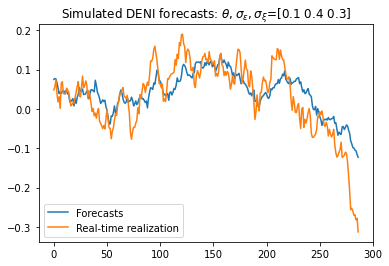

In [190]:
if __name__ == "__main__":
    ## plot for validation 
    simulated_deniar  = deniar1.SimForecasts()
    plt.title(r"Simulated DENI forecasts: $\theta,\sigma_\epsilon,\sigma_\xi$={}".format(deni_exp_paras_fake))
    plt.plot(simulated_deniar['Forecast'],label='Forecasts')
    plt.plot(deniar1.real_time,label='Real-time realization')
    plt.legend(loc=0)

###  Diagnostic Expectation and Noisy Information Hybrid(DENI) + SV



In [191]:
@jitclass(model_sv_data)
class DENIHybridSV:
    def __init__(self,
                 exp_para,
                 process_para,
                 real_time,
                 history,
                 horizon = 1):
        self.exp_para = exp_para
        self.process_para = process_para
        self.horizon = horizon
        self.real_time = real_time
        self.history = history

    def GetRealization(self,
                       realized_series):
        self.realized = realized_series
              
    def SimForecasts(self,
                     n_sim = 500):
        ## inputs 
        real_time = self.real_time
        history  = self.history
        n = len(real_time[0,:])
        horizon = self.horizon
        n_history = len(history[0,:]) # of course equal to len(history)
        n_burn = n_history - n
        
        ## get the information set 
        infoset = history 
        y_now, p_now, sigmas_p_now, sigmas_t_now= infoset[0,:],infoset[1,:],infoset[2,:],infoset[3,:]
        sigmas_now = np.concatenate((sigmas_p_now,sigmas_t_now),axis=0).reshape((2,-1))
        
        ## process parameters
        γ = self.process_para
        ## exp parameters 
        theta, sigma_pb,sigma_pr = self.exp_para
        var_init = 2
        
        ## other parameters 
        sigma_v = np.array([[sigma_pb**2,0.0],[0.0,sigma_pr**2]]) ## variance matrix of signal noises         
        ## simulate signals 
        nb_s = 2                                    ## the number of signals 
        H = np.array([[1.0],[1.0]])                 ## an multiplicative matrix summing all signals
        
        # randomly simulated signals 
        np.random.seed(12434)
        ##########################################################
        signal_pb = p_now+sigma_pb*np.random.randn(n_history)   ## one series of public signals 
        signals_pb = signal_pb.repeat(n_sim).reshape((-1,n_sim)).T     ## shared by all agents
        np.random.seed(13435)
        signals_pr = p_now + sigma_pr*np.random.randn(n_sim*n_history).reshape((n_sim,n_history))
        #####################################################################################

        ## prepare matrices
        nowcasts_to_burn = np.zeros((n_sim,n_history))
        nowcasts_to_burn[:,0] = p_now[0]
        nowvars_to_burn = np.zeros((n_sim,n_history))
        nowvars_to_burn[:,0] = var_init
        Vars_to_burn = np.zeros((n_sim,n_history))
        
        ## fill the matrices for individual moments
        for i in range(n_sim):
            signals_this_i = np.concatenate((signals_pb[i,:],signals_pr[i,:]),axis=0).reshape((2,-1))
            ## the histories signals specific to i: the first row is public signals and the second is private signals 
            Pkalman = np.zeros((n_history,nb_s))
            ## Kalman gains of this agent for respective signals 
            Pkalman[0,:] = 0  ## some initial values 
            
            for t in range(n_history-1):
                step1var = hstepvarSV(1,
                                      sigmas_now[:,t],
                                      γ[0])
                step1_vars_to_burn = nowvars_to_burn[i,t] + step1var
                ## prior uncertainty
                
                inv = np.linalg.inv(H*step1_vars_to_burn*H.T+sigma_v) 
                ## the inverse of the noisiness matrix
                
                inv_sc = np.dot(np.dot(H.T,inv),H)
                ## the total noisiness as a scalar 
                
                var_reduc = step1_vars_to_burn*inv_sc*step1_vars_to_burn
                ## reduction in uncertainty from the update
                
                nowvars_this_2d = np.array([[step1_vars_to_burn]]) - var_reduc
                ## update equation of nowcasting uncertainty 
                
                nowvars_to_burn[i,t+1] = nowvars_this_2d[0,0] 
                ## nowvars_this_2d is a 2-d matrix with only one entry. We take the element and set it to the matrix
                ### this is necessary for Numba typing 
                
                Pkalman[t+1,:] = step1_vars_to_burn*np.dot(H.T,np.linalg.inv(H*step1_vars_to_burn*H.T+sigma_v))
                ## update Kalman gains recursively using the signal extraction ratios 
                
                Pkalman_all = np.dot(Pkalman[t+1,:],H)[0] 
                ## the weight to the prior forecast 
    
                nowcasts_to_burn[i,t+1] = (1-(1+theta)*Pkalman_all)*nowcasts_to_burn[i,t]+ np.dot((1+theta)*Pkalman[t+1,:],signals_this_i[:,t+1])
                ## kalman filtering updating for nowcasting: weighted average of prior and signals 
                
            for t in range(n_history):
                stephvar = hstepvarSV(horizon,
                                      sigmas_now[:,t],
                                      γ[0])
                Vars_to_burn[i,t] = nowvars_to_burn[i,t] + stephvar
                
        nowcasts = nowcasts_to_burn[:,n_burn:]
        forecasts = nowcasts 
        Vars = Vars_to_burn[:,n_burn:]

        
        ## compute population moments
        forecasts_mean = np_mean(forecasts,axis=0)
        forecasts_var = np_var(forecasts,axis=0)
        FEs_mean = forecasts_mean - self.realized
        Vars_mean = np_mean(Vars,axis=0) ## need to change for time-variant volatility
        
        forecast_moments_sim = {"Forecast":forecasts_mean,
                                "FE":FEs_mean,
                                "Disg":forecasts_var,
                                "Var":Vars_mean}
        return forecast_moments_sim
        
    def SMM(self):
        
        γ = self.process_para
        horizon = self.horizon 
        #################################
        # inflation moments 
        #################################

        InfAV  = 0.0
        InfVar = np.nan
        InfATV = np.nan
        
        #################################
        # expectation moments 
        #################################
        ## simulate forecasts
        moms_sim = self.SimForecasts()
        Forecasts_sim = moms_sim['Forecast']
        FEs_sim = moms_sim['FE']
        Disgs_sim = moms_sim['Disg']
        Vars_sim = moms_sim['Var']
        
        ## SMM moments     
        Forecast_sim = np.mean(Forecasts_sim)
        FE_sim = np.mean(FEs_sim)
        FEVar_sim = np.var(FEs_sim)
        FEATV_sim = np.cov(np.stack( (FEs_sim[horizon:],FEs_sim[:-horizon]),axis = 0 ))[0,1]
        Disg_sim = np.mean(Disgs_sim)
        DisgVar_sim = np.var(Disgs_sim)
        DisgATV_sim = np.cov(np.stack( (Disgs_sim[horizon:],Disgs_sim[:-horizon]),axis = 0))[0,1]
        
        Var_sim = np.mean(Vars_sim)
        VarVar_sim = np.var(Vars_sim)
        VarATV_sim = np.cov(np.stack( (Vars_sim[horizon:],Vars_sim[:-horizon]),axis = 0))[0,1]
    
        SMMMoments = {"InfAV":InfAV,
                      "InfVar":InfVar,
                      "InfATV":InfATV,
                      "Forecast":Forecast_sim,
                      "FE":FE_sim,
                      "FEVar":FEVar_sim,
                      "FEATV":FEATV_sim,
                      "Disg":Disg_sim,
                      "DisgVar":DisgVar_sim,
                      "DisgATV":DisgATV_sim,
                      "Var":Var_sim,
                      'VarVar':VarVar_sim,
                      'VarATV':VarATV_sim}
        return SMMMoments

In [192]:
if __name__ == "__main__":
    ## initial a sv instance
    denisv0 = DENIHybridSV(exp_para = np.array([0.1,0.3,0.2]),
                               process_para = np.array([0.1]),
                               real_time = xx_real_time,
                               history = xx_real_time) ## history does not matter here, 

    ## get the realization 

    denisv0.GetRealization(xx_realized)